In [1]:
import os
import sys
import time

import numpy as np
import torch
import pandas as pd

import matplotlib.pyplot as plt

import scipy.io.wavfile as wav

import importlib
import librosa
import soundfile as sf

import torchnet.meter as tnt
from collections import OrderedDict

from IPython.display import clear_output
from scipy.io.wavfile import write
import IPython

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))
sys.path.append(os.path.join(os.getcwd(), '../datasets/'))

import ai8x

from types import SimpleNamespace
from msnoise import MSnoise
import msnoise

from mixedkws import MixedKWS
import mixedkws


from torchvision import transforms

In [2]:
'''
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v2_0911Speed_DynAug","qat_best.pth.tar")              #degisecek
mod = importlib.import_module("ai85net-kws20-v2")
model_file = "ai85net-kws20-v2"

'''
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v3_0911Speed_DynAug","qat_best.pth.tar")              #degisecek
mod = importlib.import_module("ai85net-kws20-v3")
model_file = "ai85net-kws20-v3"

'''
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_NAS_0911Speed_DynAug/","qat_best.pth.tar")
mod = importlib.import_module("ai85nasnet_kws20_res_1")
model_file = "ai85nasnet_kws20_res_1"
'''
dataset = importlib.import_module("kws20")

In [3]:
classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
           'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'unknown']

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=False, round_avg=False)
# qat_policy = {'start_epoch': 10, 'weight_bits': 8, 'bias_bits': 8}

Working with device: cuda
Configuring device: MAX78000, simulate=False.


In [5]:
'''
model = mod.AI85KWS20Netv2(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

'''
model = mod.AI85KWS20Netv3(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

'''
model = mod.AI85NASNET_KWS20_RES_1(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=True, 
                           quantize_activation=False)
'''
checkpoint = torch.load(trained_checkpoint_path)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
model.load_state_dict(checkpoint['state_dict'], strict=False)


ai8x.update_model(model)

In [6]:
sn = SimpleNamespace()
sn.truncate_testset = False
sn.act_mode_8bit = False

# args = ('/data_ssd', Namespace(act_mode_8bit=False, activation_stats=[], avg_pool_rounding=False, batch_size=256, cnn='ai85kws20netv3', collate_fn=None, compress='policies/schedule_kws20.yaml', cpu=False, csv_prefix=None, data='/data_ssd', dataset='KWS_20', datasets_fn=<function KWS_20_get_datasets at 0x7f917f0f2040>, deterministic=True, device='cuda', dimensions=(128, 128, 1), display_confusion=True, display_embedding=False, display_prcurves=False, earlyexit_lossweights=None, earlyexit_thresholds=None, effective_test_size=1.0, effective_train_size=1.0, effective_valid_size=1.0, epochs=200, evaluate=False, extras=None, generate_sample=None, gpus=None, kd_distill_wt=0.5, kd_pretrained=False, kd_resume='', kd_start_epoch=0, kd_student_wt=0.5, kd_teacher=None, kd_teacher_wt=0.0, kd_temp=1.0, kernel_stats=False, labels=('up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'UNKNOWN'), load_model_path='', load_serialized=False, log_params_histograms=False, lr=0.001, masks_sparsity=False, momentum=0.9, name=None, nas=False, nas_kd_resume_from='', nas_policy='', nas_stage_transition_list=None, no_tensorboard=True, num_best_scores=1, num_classes=21, obj_detection=False, obj_detection_params=None, optimizer='Adam', out_fold_ratio=1, output_dir='logs', pretrained=False, print_freq=10, qat_policy='policies/qat_policy.yaml', qe_bits_accum=32, qe_bits_acts=8, qe_bits_wts=8, qe_calibration=None, qe_clip_acts=<ClipMode.NONE: 0>, qe_clip_n_stds=None, qe_config_file=None, qe_convert_pytorch=False, qe_dynamic=False, qe_mode=<LinearQuantMode.SYMMETRIC: 1>, qe_mode_acts=None, qe_mode_wts=None, qe_no_clip_layers=[], qe_no_quant_layers=[], qe_per_channel=False, qe_pytorch_backend='fbgemm', qe_save_fp_weights=False, qe_scale_approx_bits=None, qe_stats_file=None, quantize_eval=False, regression=False, reset_optimizer=False, resumed_checkpoint_path='', seed=None, sensitivity=None, sensitivity_range=[0.0, 0.95, 0.05], shap=0, show_train_accuracy='last_batch', sparsity_perf=False, summary=None, summary_filename='model', tblog=False, thinnify=False, truncate_testset=False, use_bias=False, validation_split=0.1, visualize_fn=<function visualize_data at 0x7f8fface3790>, weight_decay=0.0, workers=4))
_, test_dataset = dataset.KWS_20_get_datasets( ('/data_ssd/', sn), load_train=False, load_test=True)
_, test_noise = msnoise.MSnoise_get_datasets(('/data_ssd/', sn), load_train=False, load_test=True)

No key `stretch` in input augmentation dictionary! Using defaults: [Min: 0.8, Max: 1.3]

Processing test...
test set: 33015 elements
Class up (# 31): 1275 elements
Class down (# 5): 1218 elements
Class left (# 15): 1236 elements
Class right (# 23): 1188 elements
Class stop (# 27): 1233 elements
Class go (# 11): 1206 elements
Class yes (# 34): 1257 elements
Class no (# 19): 1215 elements
Class on (# 21): 1188 elements
Class off (# 20): 1206 elements
Class one (# 22): 1197 elements
Class two (# 30): 1272 elements
Class three (# 28): 1215 elements
Class four (# 10): 1200 elements
Class five (# 7): 1335 elements
Class six (# 26): 1182 elements
Class seven (# 24): 1218 elements
Class eight (# 6): 1224 elements
Class nine (# 18): 1224 elements
Class zero (# 35): 1254 elements
Class UNKNOWN: 8472 elements
torch.Size([56253, 128, 128])


Class AirConditioner, 0
Number of elements in class AirConditioner: 587
AirConditioner: 0
Class AirportAnnouncements, 1
Number of elements in class AirportAnn

In [7]:
originals = list(range(0, len(test_dataset), 3))
original_testdataset  = torch.utils.data.Subset(test_dataset, originals)
test_loader = torch.utils.data.DataLoader(original_testdataset, batch_size=256)

In [8]:
noise_dict = {}

for idx, i in enumerate(test_noise.classes):

    if list(test_noise.targets).count(idx) == 0:
        continue

    else:
        noise_dict[i] = idx

In [9]:
noise_list = noise_dict.keys()
noise_list = list(noise_list)

In [10]:
noise_list.append('WhiteNoise')

In [11]:
noise_dict

{'AirConditioner': 0,
 'AirportAnnouncements': 1,
 'Babble': 2,
 'Bus': 3,
 'CafeTeria': 4,
 'Car': 5,
 'CopyMachine': 6,
 'Office': 8,
 'ShuttingDoor': 10,
 'Typing': 12,
 'VacuumCleaner': 13,
 'Washing': 14}

In [12]:
def evaluate(db, noise, noise_kind):

    if (noise == True) and (noise_kind == None):
        print('Noise kind is not specified. Noise will not be applied.')
        noise = False

    model.eval()
    model.to(device)
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
    outputs_all = np.zeros((len(test_dataset), 21))
    targets_all = np.zeros((len(test_dataset)))

    transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
    if (noise == True) and (noise_kind != 'WhiteNoise'):
        test_noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                 transform=transform, quantize=True, download=False)
        
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):

            if noise == True:
                if noise_kind == 'WhiteNoise':
                    mean = 0
                    std = 1
                    random_noise = np.random.normal(mean, std, inputs.shape)
                    random_noise = torch.tensor(random_noise, dtype = torch.float32)
                    random_noise = np.clip(random_noise, -1, 1)
                else:
                    if (test_noise_dataset.data.shape[0] >= inputs.shape[0]):
                        random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                    else:
                        small_indx = np.random.randint(0, test_noise_dataset.data.shape[0], (inputs.shape[0] - test_noise_dataset.data.shape[0]))
                        random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                        random_noise = torch.cat([random_noise, random_noise[small_indx]], dim=0)
                inputs = MixedKWS.snr_mixer(inputs, random_noise, db)

            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            classerr.add(outputs, targets)

            print("Batch: [",batch_idx*256 ,"/", len(original_testdataset),"]")
            acc = classerr.value()[0]
            print("Accuracy: ", acc)
            outputs_all[batch_idx*256:batch_idx*256+len(inputs)] = outputs.cpu().numpy()
            targets_all[batch_idx*256:batch_idx*256+len(inputs)] = targets.cpu().numpy()
            
    print("Total Accuracy: ", acc)
    return acc

In [13]:
def snr_testing(noise = False, noise_kind = None):

    if noise == False:
        db = None

    time_s = time.time()
    print("Started evaluating :", trained_checkpoint_path)

    if noise == False:
        accuracies = np.zeros(1)
        snr = np.zeros(1)

        accuracies[0] = evaluate(db, noise, noise_kind)
        snr[0] = None
        
        dur = time.time() - time_s
        print(f'Finished in {dur:.3f} seconds.')
        return accuracies, snr
    
    accuracies = np.zeros(4)
    snr = np.zeros(4)

    for idx, db in enumerate([-5, 0, 10, 20]):
        print("Evaluating SNR levels of", db)
        accuracies[idx] = evaluate(db, noise, noise_kind)
        snr[idx] = db
    
    dur = time.time() - time_s
    print(f'Finished in {dur:.3f} seconds.')
    return accuracies, snr

In [14]:
def benchmark(noise_kinds):

    num = len(noise_kinds) + 1

    snr = np.zeros((num, 4))
    accuracies = np.zeros((num, 4))

    for idx, n in enumerate(noise_kinds):

        print(f'{n} Noise Evaluation')

        accuracies[idx], snr[idx] = snr_testing(noise = True, noise_kind = n)


    accuracies[-1], snr[-1] = snr_testing(noise= False)


    return accuracies, snr

In [15]:
noise_list

['AirConditioner',
 'AirportAnnouncements',
 'Babble',
 'Bus',
 'CafeTeria',
 'Car',
 'CopyMachine',
 'Office',
 'ShuttingDoor',
 'Typing',
 'VacuumCleaner',
 'Washing',
 'WhiteNoise']

In [166]:
accuracies_w, snr_w = benchmark('WhiteNoise')

W Noise Evaluation
Started evaluating : /home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v3_0911Speed_DynAug/qat_best.pth.tar
Evaluating SNR levels of -5


AttributeError: 'dict' object has no attribute 'eval'

### Test Noise

In [165]:
noise_kind = 'Washing'
idx = 100

transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
test_noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                transform=transform, quantize=True, download=False)

random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=256, shuffle = True)))[0]
write(f'/home/merveeyuboglu/Github/ai8x-training/codes/{noise_kind}.wav', 16384, np.array(random_noise[idx]).flatten('F'))

torch.Size([56253, 128, 128])


Class Washing, 25
Number of elements in class Washing: 1197
Washing: 0
Number of elements in class unknown: 27738
[0]




In [159]:
random_noise.mean(), random_noise.max(), random_noise.min()

(tensor(-9.4827e-06), tensor(0.2656), tensor(-0.3516))

## Examples

In [17]:
def snr_mixer_manuel(clean, noise, snr):
    # Normalizing to rms equal to 1
    rmsclean = torch.mean(clean[:, :125]**2)**0.5
    scalarclean = 1 / rmsclean
    clean = clean * scalarclean

    rmsnoise = torch.mean(noise[:, :125]**2)**0.5
    scalarnoise = 1 / rmsnoise
    noise = noise * scalarnoise

    # Set the noise level for a given SNR
    cleanfactor = 10**(snr/20)
    noisyspeech = cleanfactor*clean + noise
    noisyspeech2 = noisyspeech / (scalarnoise + cleanfactor * scalarclean)

    plots = (cleanfactor*clean , noise, noisyspeech)
    return noisyspeech2, plots

### Babble Example

#### Codes

In [81]:
noise = True
noise_kind = 'Babble'
idx = 0

transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
if (noise == True) and (noise_kind != 'WhiteNoise'):
    test_noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                transform=transform, quantize=True, download=False)
    
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if noise == True:
            if noise_kind == 'WhiteNoise':
                mean = 0
                std = 1
                random_noise = np.random.normal(mean, std, inputs.shape)
                random_noise = torch.tensor(random_noise, dtype = torch.float32)
                random_noise = np.clip(random_noise, -1, 1)
            else:
                if (test_noise_dataset.data.shape[0] >= inputs.shape[0]):
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                else:
                    small_indx = np.random.randint(0, test_noise_dataset.data.shape[0], (inputs.shape[0] - test_noise_dataset.data.shape[0]))
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                    random_noise = torch.cat([random_noise, random_noise[small_indx]], dim=0)
                    
            print('Random Noise')
            print(f'Noise max: {random_noise[idx].max()}')
            print(f'Noise min: {random_noise[idx].min()}')
            print(f'Noise mean: {random_noise[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/noise.wav', 16384, np.array(random_noise[idx]).flatten('F'))

            print('Inputs')
            print(f'Input max: {inputs[idx].max()}')
            print(f'Input min: {inputs[idx].min()}')
            print(f'Input mean: {inputs[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/input.wav', 16384, np.array(inputs[idx]).flatten('F'))

            mixed_5,plot_5 = snr_mixer_manuel(inputs, random_noise, -5)

            print('SNR Mixer -5db')
            print(f'Input max: {mixed_5[idx].max()}')
            print(f'Input min: {mixed_5[idx].min()}')
            print(f'Input mean: {mixed_5[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/mixed-5.wav', 16384, np.array(mixed_5[idx]).flatten('F'))

            mixed_0,plot_0 = snr_mixer_manuel(inputs, random_noise, 0)

            print('SNR Mixer 0db')
            print(f'Input max: {mixed_0[idx].max()}')
            print(f'Input min: {mixed_0[idx].min()}')
            print(f'Input mean: {mixed_0[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/mixed0.wav', 16384, np.array(mixed_0[idx]).flatten('F'))

            mixed_20,plot_20 = snr_mixer_manuel(inputs, random_noise, 20)

            print('SNR Mixer 20db')
            print(f'Input max: {mixed_20[idx].max()}')
            print(f'Input min: {mixed_20[idx].min()}')
            print(f'Input mean: {mixed_20[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/mixed20.wav', 16384, np.array(mixed_20[idx]).flatten('F'))
            break

torch.Size([56253, 128, 128])


Class Babble, 2
Number of elements in class Babble: 620
Babble: 0
Number of elements in class unknown: 28315
[0]


Random Noise
Noise max: 0.4765625
Noise min: -0.515625
Noise mean: -9.870529174804688e-05

Inputs
Input max: 0.4453125
Input min: -0.3125
Input mean: 0.00022268295288085938

SNR Mixer -5db
Input max: 0.2969343364238739
Input min: -0.31832849979400635
Input mean: 2.2434076527133584e-05

SNR Mixer 0db
Input max: 0.28261855244636536
Input min: -0.24435462057590485
Input mean: 6.785368896089494e-05

SNR Mixer 20db
Input max: 0.40876686573028564
Input min: -0.2845924496650696
Input mean: 0.00019534840248525143



#### Audios

input audio

In [83]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/input.wav', rate = 16384)

noise audio

In [84]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/noise.wav', rate = 16384)

snr mixed -5db

In [85]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/mixed-5.wav', rate = 16384)

snr mixed 0db

In [86]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/mixed0.wav', rate = 16384)

snr mixed 20db

In [87]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/babble/mixed20.wav', rate = 16384)

#### Plots

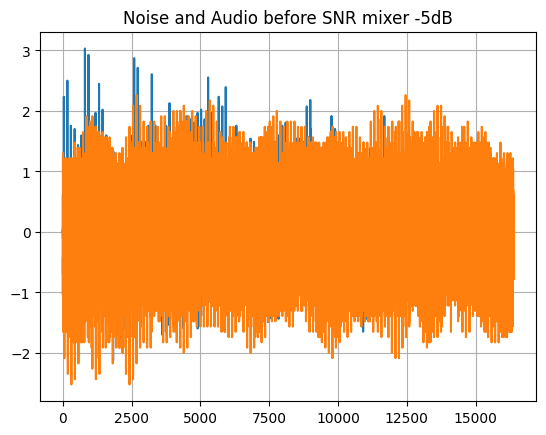

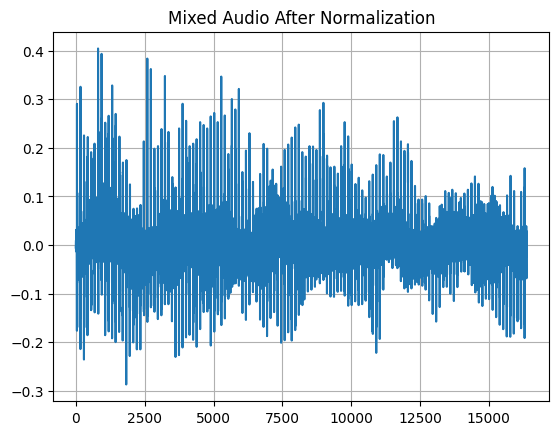

In [24]:
clean_5, noise_5, noisyspeech_5 = plot_5
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer -5dB')
plt.plot(clean_5[idx].flatten())
plt.plot(noise_5[idx].flatten())

plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_20[idx].flatten())

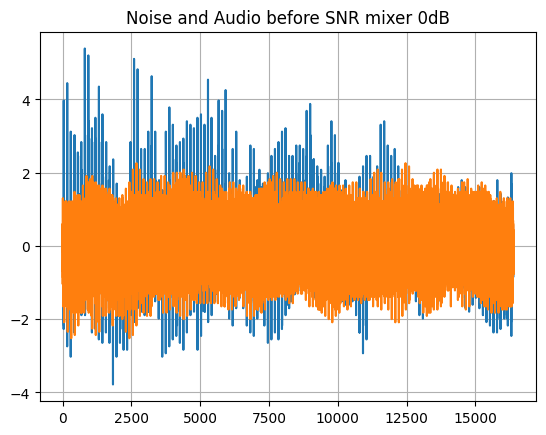

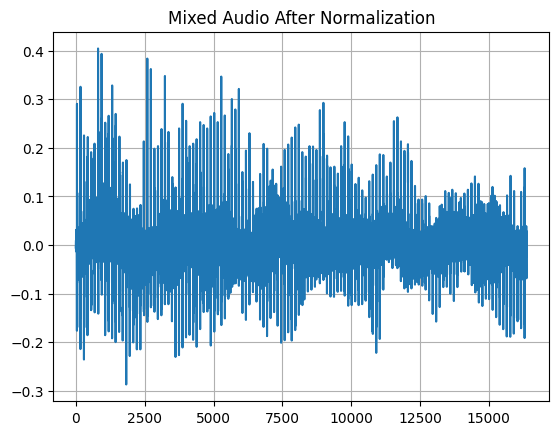

In [25]:
clean0, noise0, noisyspeech0 = plot_0
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 0dB')
plt.plot(clean0[idx].flatten())
plt.plot(noise0[idx].flatten())

plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_20[idx].flatten())

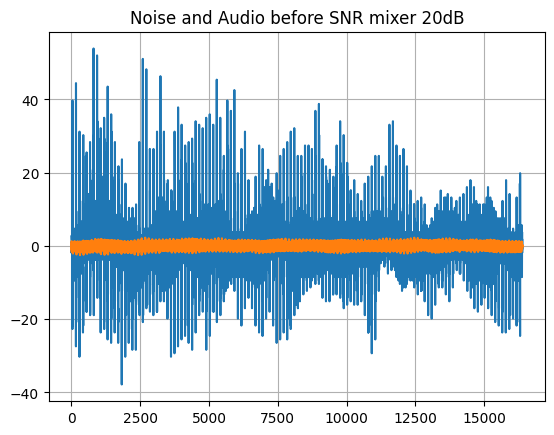

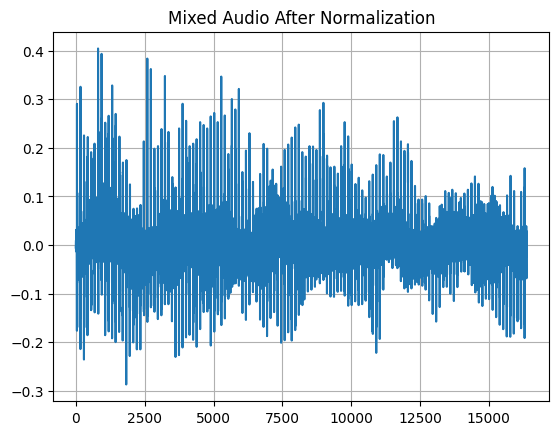

In [26]:
clean20, noise20, noisyspeech20 = plot_20
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 20dB')
plt.plot(clean20[idx].flatten())
plt.plot(noise20[idx].flatten())

plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_20[idx].flatten())

### Vacuum Cleaner Example

#### Codes

In [27]:
noise = True
noise_kind = 'VacuumCleaner'
idx = 0

transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
if (noise == True) and (noise_kind != 'WhiteNoise'):
    test_noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                transform=transform, quantize=True, download=False)
    
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if noise == True:
            if noise_kind == 'WhiteNoise':
                mean = 0
                std = 1
                random_noise = np.random.normal(mean, std, inputs.shape)
                random_noise = torch.tensor(random_noise, dtype = torch.float32)
                random_noise = np.clip(random_noise, -1, 1)
            else:
                if (test_noise_dataset.data.shape[0] >= inputs.shape[0]):
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                else:
                    small_indx = np.random.randint(0, test_noise_dataset.data.shape[0], (inputs.shape[0] - test_noise_dataset.data.shape[0]))
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                    random_noise = torch.cat([random_noise, random_noise[small_indx]], dim=0)
            print('Random Noise')
            print(f'Noise max: {random_noise[idx].max()}')
            print(f'Noise min: {random_noise[idx].min()}')
            print(f'Noise mean: {random_noise[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/noise.wav', 16384, np.array(random_noise[0]).flatten('F'))

            print('Inputs')
            print(f'Input max: {inputs[idx].max()}')
            print(f'Input min: {inputs[idx].min()}')
            print(f'Input mean: {inputs[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/input.wav', 16384, np.array(inputs[0]).flatten('F'))

            mixed_5,plot_5 = snr_mixer_manuel(inputs, random_noise, -5)

            print('SNR Mixer -5db')
            print(f'Input max: {mixed_5[idx].max()}')
            print(f'Input min: {mixed_5[idx].min()}')
            print(f'Input mean: {mixed_5[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed-5.wav', 16384, np.array(mixed_5[0]).flatten('F'))

            mixed_0,plot_0 = snr_mixer_manuel(inputs, random_noise, 0)

            print('SNR Mixer 0db')
            print(f'Input max: {mixed_0[idx].max()}')
            print(f'Input min: {mixed_0[idx].min()}')
            print(f'Input mean: {mixed_0[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed0.wav', 16384, np.array(mixed_0[0]).flatten('F'))

            mixed_20,plot_20 = snr_mixer_manuel(inputs, random_noise, 20)

            print('SNR Mixer 20db')
            print(f'Input max: {mixed_20[idx].max()}')
            print(f'Input min: {mixed_20[idx].min()}')
            print(f'Input mean: {mixed_20[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed20.wav', 16384, np.array(mixed_20[0]).flatten('F'))
        break

torch.Size([56253, 128, 128])


Class VacuumCleaner, 23
Number of elements in class VacuumCleaner: 894
VacuumCleaner: 0
Number of elements in class unknown: 28041
[0]


Random Noise
Noise max: 0.2265625
Noise min: -0.2578125
Noise mean: 1.9550323486328125e-05

Inputs
Input max: 0.4453125
Input min: -0.3125
Input mean: 0.00022268295288085938

SNR Mixer -5db
Input max: 0.21670109033584595
Input min: -0.1714252233505249
Input mean: 9.62123231147416e-05

SNR Mixer 0db
Input max: 0.2686041593551636
Input min: -0.1672854721546173
Input mean: 0.00012492564565036446

SNR Mixer 20db
Input max: 0.4141401946544647
Input min: -0.28066450357437134
Input mean: 0.00020543806022033095



#### Audios

input audio

In [28]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/input.wav', rate = 16384)

noise audio

In [29]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/noise.wav', rate = 16384)

snr mixed -5db

In [30]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed-5.wav', rate = 16384)

snr mixed 0db

In [31]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed0.wav', rate = 16384)

snr mixed 20db

In [32]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/vacuumcleaner/mixed20.wav', rate = 16384)

#### Plots

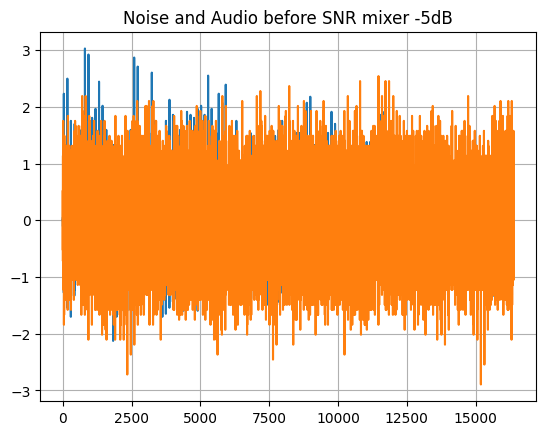

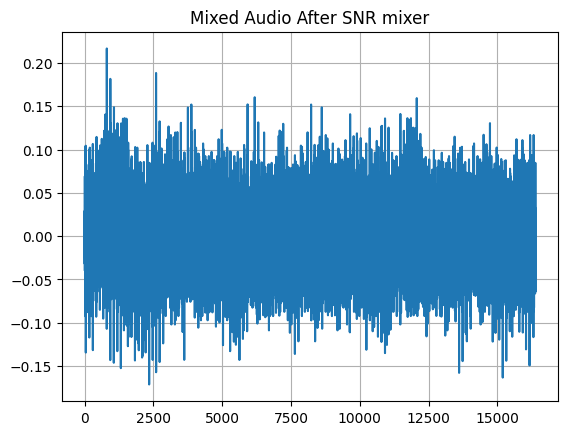

In [33]:
clean_5, noise_5, noisyspeech_5 = plot_5
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer -5dB')
plt.plot(clean_5[idx].flatten())
plt.plot(noise_5[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After SNR mixer')
plt.plot(mixed_5[idx].flatten())

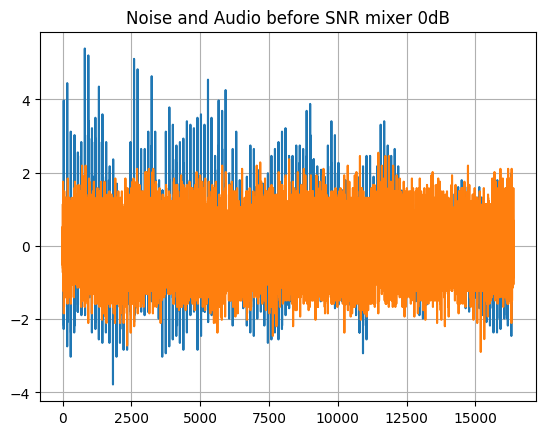

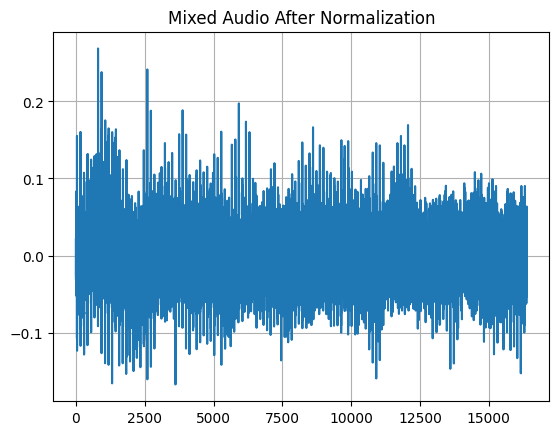

In [34]:
clean0, noise0, noisyspeech0 = plot_0
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 0dB')
plt.plot(clean0[idx].flatten())
plt.plot(noise0[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_0[idx].flatten())

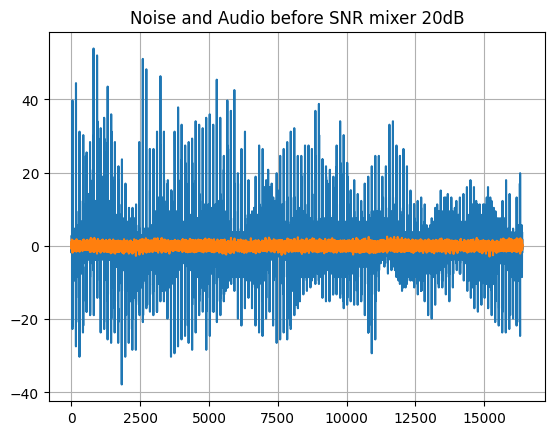

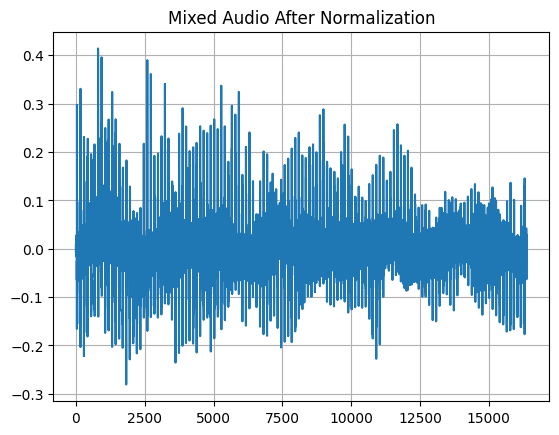

In [35]:
clean20, noise20, noisyspeech20 = plot_20
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 20dB')
plt.plot(clean20[idx].flatten())
plt.plot(noise20[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_20[idx].flatten())

### Typing Example

#### Codes

In [36]:
noise = True
noise_kind = 'Typing'
idx = 0

transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
if (noise == True) and (noise_kind != 'WhiteNoise'):
    test_noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                transform=transform, quantize=True, download=False)
    
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if noise == True:
            if noise_kind == 'WhiteNoise':
                mean = 0
                std = 1
                random_noise = np.random.normal(mean, std, inputs.shape)
                random_noise = torch.tensor(random_noise, dtype = torch.float32)
                random_noise = np.clip(random_noise, -1, 1)
            else:
                if (test_noise_dataset.data.shape[0] >= inputs.shape[0]):
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                else:
                    small_indx = np.random.randint(0, test_noise_dataset.data.shape[0], (inputs.shape[0] - test_noise_dataset.data.shape[0]))
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                    random_noise = torch.cat([random_noise, random_noise[small_indx]], dim=0)

            print('Random Noise')
            print(f'Noise max: {random_noise[idx].max()}')
            print(f'Noise min: {random_noise[idx].min()}')
            print(f'Noise mean: {random_noise[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/noise.wav', 16384, np.array(random_noise[0]).flatten('F'))

            print('Inputs')
            print(f'Input max: {inputs[idx].max()}')
            print(f'Input min: {inputs[idx].min()}')
            print(f'Input mean: {inputs[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/input.wav', 16384, np.array(inputs[0]).flatten('F'))

            mixed_5,plot_5 = snr_mixer_manuel(inputs, random_noise, -5)

            print('SNR Mixer -5db')
            print(f'Input max: {mixed_5[idx].max()}')
            print(f'Input min: {mixed_5[idx].min()}')
            print(f'Input mean: {mixed_5[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed-5.wav', 16384, np.array(mixed_5[0]).flatten('F'))

            mixed_0,plot_0 = snr_mixer_manuel(inputs, random_noise, 0)

            print('SNR Mixer 0db')
            print(f'Input max: {mixed_0[idx].max()}')
            print(f'Input min: {mixed_0[idx].min()}')
            print(f'Input mean: {mixed_0[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed0.wav', 16384, np.array(mixed_0[0]).flatten('F'))

            mixed_20,plot_20 = snr_mixer_manuel(inputs, random_noise, 20)

            print('SNR Mixer 20db')
            print(f'Input max: {mixed_20[idx].max()}')
            print(f'Input min: {mixed_20[idx].min()}')
            print(f'Input mean: {mixed_20[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed20.wav', 16384, np.array(mixed_20[0]).flatten('F'))
        break

torch.Size([56253, 128, 128])


Class Typing, 22
Number of elements in class Typing: 2058
Typing: 0
Number of elements in class unknown: 26877
[0]


Random Noise
Noise max: 0.515625
Noise min: -0.6015625
Noise mean: -1.430511474609375e-06

Inputs
Input max: 0.4453125
Input min: -0.3125
Input mean: 0.00022268295288085938

SNR Mixer -5db
Input max: 0.430040180683136
Input min: -0.5017135143280029
Input mean: 3.576843300834298e-05

SNR Mixer 0db
Input max: 0.3808426260948181
Input min: -0.4443163573741913
Input mean: 5.7151904911734164e-05

SNR Mixer 20db
Input max: 0.34720563888549805
Input min: -0.2436531037092209
Input mean: 0.00017330850823782384



#### Audios

input audio

In [37]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/input.wav', rate = 16384)

noise audio

In [38]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/noise.wav', rate = 16384)

snr mixed -5db

In [39]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed-5.wav', rate = 16384)

snr mixed 0db

In [40]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed0.wav', rate = 16384)

snr mixed 20db

In [41]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/typing/mixed20.wav', rate = 16384)

#### Plots

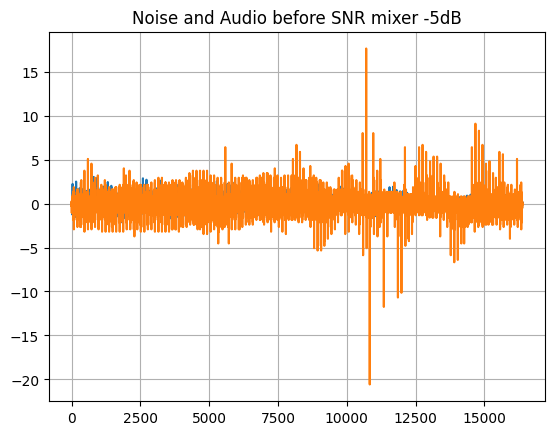

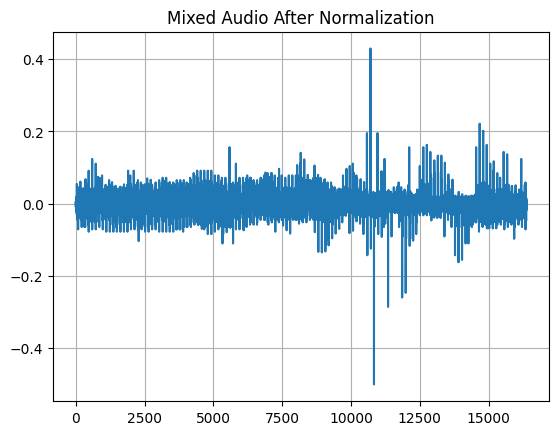

In [42]:
clean_5, noise_5, noisyspeech_5 = plot_5
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer -5dB')
plt.plot(clean_5[idx].flatten())
plt.plot(noise_5[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_5[idx].flatten())

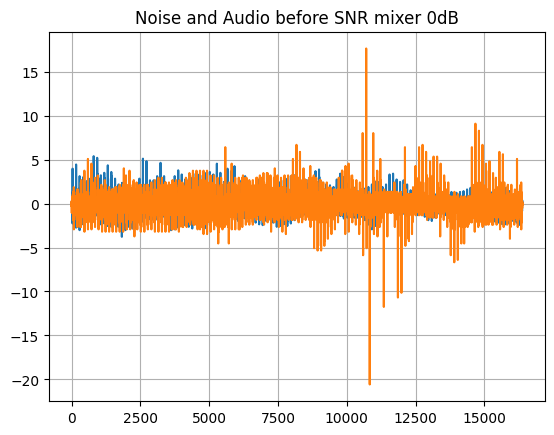

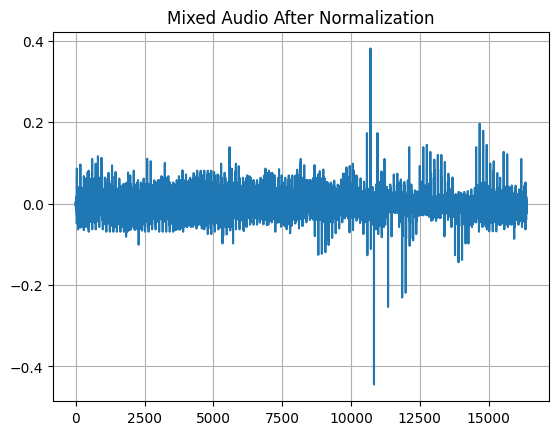

In [43]:
clean0, noise0, noisyspeech0 = plot_0
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 0dB')
plt.plot(clean0[idx].flatten())
plt.plot(noise0[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_0[idx].flatten())

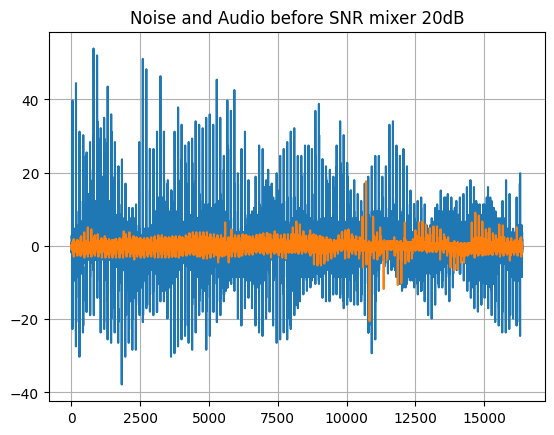

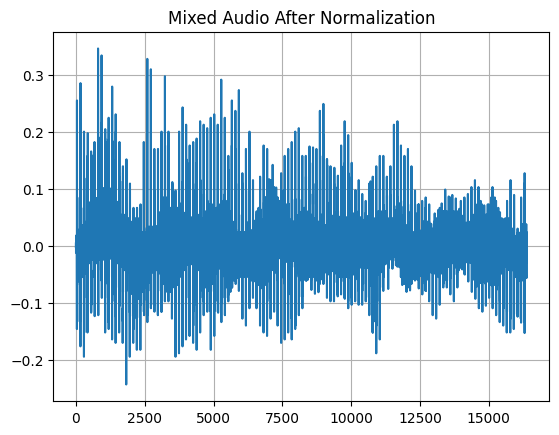

In [44]:
clean20, noise20, noisyspeech20 = plot_20
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 20dB')
plt.plot(clean20[idx].flatten())
plt.plot(noise20[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_20[idx].flatten())

### WhiteNoise Example

#### Codes

In [45]:
noise = True
noise_kind = 'WhiteNoise'
idx = 0

transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
if (noise == True) and (noise_kind != 'WhiteNoise'):
    test_noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', remove_unknowns=True,
                transform=transform, quantize=True, download=False)
    
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if noise == True:
            if noise_kind == 'WhiteNoise':
                mean = 0
                std = 1
                random_noise = np.random.normal(mean, std, inputs.shape)
                random_noise = torch.tensor(random_noise, dtype = torch.float32)
                random_noise = np.clip(random_noise, -1, 1)
            else:
                if (test_noise_dataset.data.shape[0] >= inputs.shape[0]):
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                else:
                    small_indx = np.random.randint(0, test_noise_dataset.data.shape[0], (inputs.shape[0] - test_noise_dataset.data.shape[0]))
                    random_noise = next(iter(torch.utils.data.DataLoader(test_noise_dataset, batch_size=inputs.shape[0], shuffle = True)))[0]
                    random_noise = torch.cat([random_noise, random_noise[small_indx]], dim=0)

            print('Random Noise')
            print(f'Noise max: {random_noise[idx].max()}')
            print(f'Noise min: {random_noise[idx].min()}')
            print(f'Noise mean: {random_noise[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/noise.wav', 16384, np.array(random_noise[0]).flatten('F'))

            print('Inputs')
            print(f'Input max: {inputs[idx].max()}')
            print(f'Input min: {inputs[idx].min()}')
            print(f'Input mean: {inputs[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/input.wav', 16384, np.array(inputs[0]).flatten('F'))

            mixed_5,plot_5 = snr_mixer_manuel(inputs, random_noise, -5)

            print('SNR Mixer -5db')
            print(f'Input max: {mixed_5[idx].max()}')
            print(f'Input min: {mixed_5[idx].min()}')
            print(f'Input mean: {mixed_5[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed-5.wav', 16384, np.array(mixed_5[0]).flatten('F'))

            mixed_0,plot_0 = snr_mixer_manuel(inputs, random_noise, 0)

            print('SNR Mixer 0db')
            print(f'Input max: {mixed_0[idx].max()}')
            print(f'Input min: {mixed_0[idx].min()}')
            print(f'Input mean: {mixed_0[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed0.wav', 16384, np.array(mixed_0[0]).flatten('F'))

            mixed_20,plot_20 = snr_mixer_manuel(inputs, random_noise, 20)

            print('SNR Mixer 20db')
            print(f'Input max: {mixed_20[idx].max()}')
            print(f'Input min: {mixed_20[idx].min()}')
            print(f'Input mean: {mixed_20[idx].mean()}\n')
            write('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed20.wav', 16384, np.array(mixed_20[0]).flatten('F'))
        break

Random Noise
Noise max: 1.0
Noise min: -1.0
Noise mean: -0.005484201014041901

Inputs
Input max: 0.4453125
Input min: -0.3125
Input mean: 0.00022268295288085938

SNR Mixer -5db
Input max: 0.5264816284179688
Input min: -0.4086291491985321
Input mean: -0.0007458959007635713

SNR Mixer 0db
Input max: 0.4884864389896393
Input min: -0.3708949685096741
Input mean: -0.00036569376243278384

SNR Mixer 20db
Input max: 0.4495680034160614
Input min: -0.3189367651939392
Input mean: 0.00015782739501446486



#### Audios

input audio

In [46]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/input.wav', rate = 16384)

noise audio

In [47]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/noise.wav', rate = 16384)

snr mixed -5db

In [48]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed-5.wav', rate = 16384)

snr mixed 0db

In [49]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed0.wav', rate = 16384)

snr mixed 20db

In [50]:
IPython.display.Audio('/home/merveeyuboglu/Github/ai8x-training/codes/audios/whitenoise/mixed20.wav', rate = 16384)

#### Plots

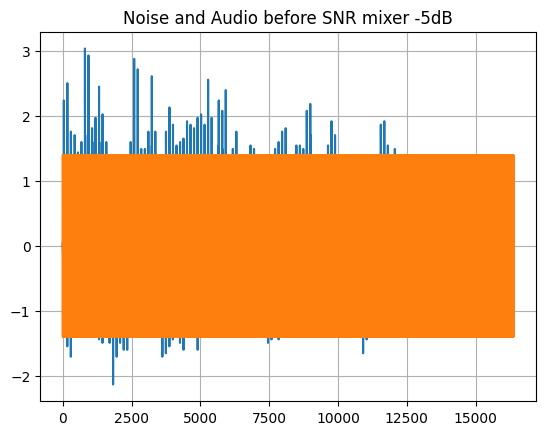

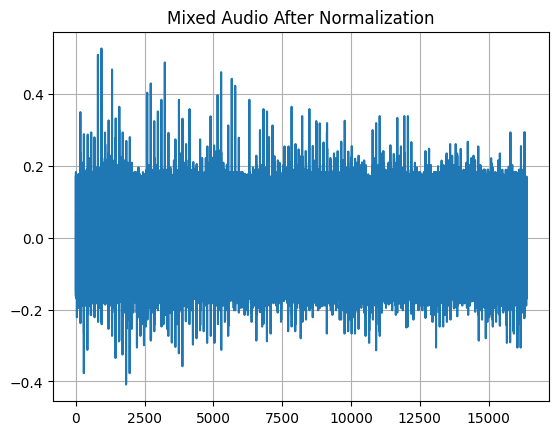

In [51]:
clean_5, noise_5, noisyspeech_5 = plot_5
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer -5dB')
plt.plot(clean_5[idx].flatten())
plt.plot(noise_5[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_5[idx].flatten())

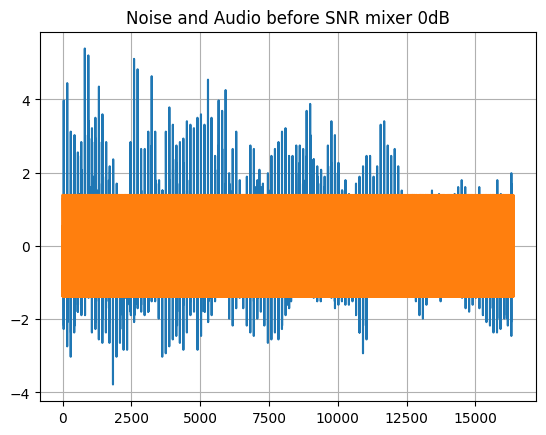

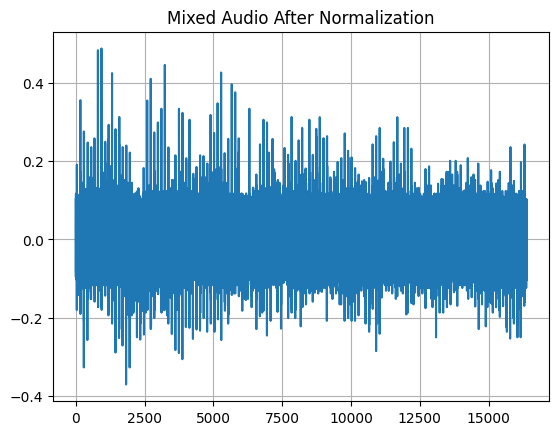

In [52]:
clean0, noise0, noisyspeech0 = plot_0
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 0dB')
plt.plot(clean0[idx].flatten())
plt.plot(noise0[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_0[idx].flatten())

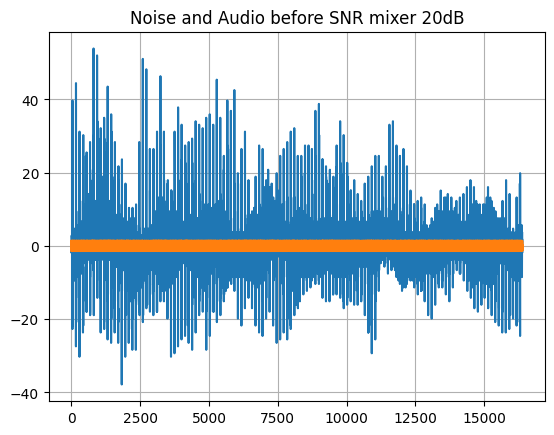

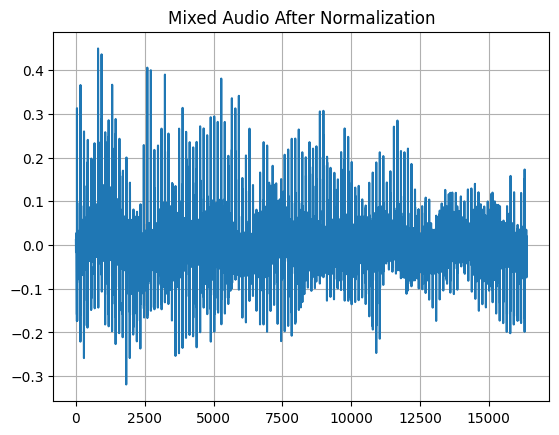

In [53]:
clean20, noise20, noisyspeech20 = plot_20
plt.figure()
plt.grid()
plt.title('Noise and Audio before SNR mixer 20dB')
plt.plot(clean20[idx].flatten())
plt.plot(noise20[idx].flatten())
plt.figure()
plt.grid()
plt.title('Mixed Audio After Normalization')
plt.plot(mixed_20[idx].flatten())

## CSV Application

In [54]:
snr = [-5, 0, 10, 20]

In [55]:
csv ={}

for idx, i in enumerate(noise_list):
    csv[i] = accuracies_w[idx]
    
csv_list = []

csv_list.append(['raw', 'None', accuracies_w[-1][0]])
for i in csv.keys():
    for idx, j in enumerate(csv[i]):
        csv_list.append([i, snr[idx], j])

In [56]:
csv_list

[['raw', 'None', 90.80417991821899],
 ['AirConditioner', -5, 36.556110858700585],
 ['AirConditioner', 0, 53.08496138119037],
 ['AirConditioner', 10, 78.38255338482509],
 ['AirConditioner', 20, 88.3053157655611],
 ['AirportAnnouncements', -5, 34.24806905951841],
 ['AirportAnnouncements', 0, 47.44207178555202],
 ['AirportAnnouncements', 10, 72.4670604270786],
 ['AirportAnnouncements', 20, 86.30622444343481],
 ['Babble', -5, 24.79781917310313],
 ['Babble', 0, 38.273512039981824],
 ['Babble', 10, 68.21444797819174],
 ['Babble', 20, 84.84325306678782],
 ['Bus', -5, 74.69332121762835],
 ['Bus', 0, 82.88050885960926],
 ['Bus', 10, 89.04134484325307],
 ['Bus', 20, 90.64970467969104],
 ['CafeTeria', -5, 33.08496138119037],
 ['CafeTeria', 0, 50.222626079054976],
 ['CafeTeria', 10, 77.74647887323944],
 ['CafeTeria', 20, 88.24170831440254],
 ['Car', -5, 73.48477964561563],
 ['Car', 0, 82.21717401181282],
 ['Car', 10, 89.06860517946387],
 ['Car', 20, 90.53157655611086],
 ['CopyMachine', -5, 51.1403

In [57]:
df = pd.DataFrame(csv_list, columns = ['Type', 'SNR (dB)', f'{model_file}'])

In [58]:
df

Type SNR (dB)  ai85net-kws20-v3
0                    raw     None         90.804180
1         AirConditioner       -5         36.556111
2         AirConditioner        0         53.084961
3         AirConditioner       10         78.382553
4         AirConditioner       20         88.305316
5   AirportAnnouncements       -5         34.248069
6   AirportAnnouncements        0         47.442072
7   AirportAnnouncements       10         72.467060
8   AirportAnnouncements       20         86.306224
9                 Babble       -5         24.797819
10                Babble        0         38.273512
11                Babble       10         68.214448
12                Babble       20         84.843253
13                   Bus       -5         74.693321
14                   Bus        0         82.880509
15                   Bus       10         89.041345
16                   Bus       20         90.649705
17             CafeTeria       -5         33.084961
18             CafeTeria        0         50.222626
19             CafeTeria       10         77.746479
20             CafeTeria       20         88.241708
21                   Car       -5         73.484780
22                   Car        0         82.217174
23                   Car       10         89.068605
24                   Car       20         90.531577
25           CopyMachine       -5         51.140391
26           CopyMachine        0         64.016356
27           CopyMachine       10         81.335756
28           CopyMachine       20         88.296229
29                Office       -5         73.402999
30                Office        0         82.653339
31                Office       10         89.050432
32                Office       20         90.467969
33          ShuttingDoor       -5         63.125852
34          ShuttingDoor        0         70.395275
35          ShuttingDoor       10         81.944571
36          ShuttingDoor       20         87.878237
37                Typing       -5         43.216720
38                Typing        0         57.755566
39                Typing       10         77.937301
40                Typing       20         87.260336
41         VacuumCleaner       -5         29.486597
42         VacuumCleaner        0         42.507951
43         VacuumCleaner       10         69.259428
44         VacuumCleaner       20         83.498410
45               Washing       -5         73.157656
46               Washing        0         82.053612
47               Washing       10         89.177647
48               Washing       20         90.449796
49            WhiteNoise       -5         37.955475
50            WhiteNoise        0         57.355747
51            WhiteNoise       10         82.171740
52            WhiteNoise       20         88.968651

In [59]:
if os.path.exists('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv'):
    current = pd.read_csv('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv', decimal=',', sep=';')
    if model_file in current.columns:
        print(f'This model file ({model_file}) already exists!')
    else:
        current[model_file] = list(df[model_file].values)
        current.to_csv('acc.csv', sep=';', decimal=',', index=False)

else:
    df.to_csv('acc.csv', sep=';', decimal=',', index=False)

This model file (ai85net-kws20-v3) already exists!


In [60]:
pd.read_csv('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv', decimal=',', sep=';')

Type  SNR (dB)  ai85nasnet_kws20_res_1  ai85net-kws20-v2  \
0                    raw       NaN               93.766470         92.021808   
1         AirConditioner      -5.0               41.154021         37.101318   
2         AirConditioner       0.0               59.836438         56.065425   
3         AirConditioner      10.0               84.116311         81.517492   
4         AirConditioner      20.0               91.812812         90.213539   
5   AirportAnnouncements      -5.0               38.646070         34.784189   
6   AirportAnnouncements       0.0               52.694230         48.550659   
7   AirportAnnouncements      10.0               77.582917         75.038619   
8   AirportAnnouncements      20.0               90.413448         88.405270   
9                 Babble      -5.0               30.622444         27.323944   
10                Babble       0.0               45.343026         40.336211   
11                Babble      10.0               74.629714         71.912767   
12                Babble      20.0               89.777374         87.787369   
13                   Bus      -5.0               73.820990         74.102681   
14                   Bus       0.0               82.935030         82.571558   
15                   Bus      10.0               91.258519         90.331667   
16                   Bus      20.0               93.203090         91.749205   
17             CafeTeria      -5.0               36.892322         33.048614   
18             CafeTeria       0.0               55.365743         52.321672   
19             CafeTeria      10.0               82.553385         80.290777   
20             CafeTeria      20.0               91.976374         90.404362   
21                   Car      -5.0               70.904134         72.239891   
22                   Car       0.0               80.963199         81.962744   
23                   Car      10.0               90.913221         90.149932   
24                   Car      20.0               93.130395         91.721945   
25           CopyMachine      -5.0               55.474784         53.084961   
26           CopyMachine       0.0               69.168560         65.515675   
27           CopyMachine      10.0               85.070423         82.689687   
28           CopyMachine      20.0               91.785552         90.059064   
29                Office      -5.0               70.222626         72.303498   
30                Office       0.0               81.417537         81.808269   
31                Office      10.0               90.731486         90.304407   
32                Office      20.0               93.130395         91.803726   
33          ShuttingDoor      -5.0               63.034984         61.971831   
34          ShuttingDoor       0.0               73.003180         70.404362   
35          ShuttingDoor      10.0               85.061336         83.216720   
36          ShuttingDoor      20.0               91.194911         89.541118   
37                Typing      -5.0               44.234439         43.262154   
38                Typing       0.0               58.019082         55.629259   
39                Typing      10.0               79.654702         77.401181   
40                Typing      20.0               89.850068         88.423444   
41         VacuumCleaner      -5.0               35.929123         32.167197   
42         VacuumCleaner       0.0               50.749659         45.906406   
43         VacuumCleaner      10.0               76.855975         72.421627   
44         VacuumCleaner      20.0               89.577465         86.960473   
45               Washing      -5.0               69.931849         71.440254   
46               Washing       0.0               80.626988         81.835529   
47               Washing      10.0               90.885961         90.159019   
48               Washing      20.0               93.312131         91.740118   
49            WhiteN

## CSV Plotting

In [61]:
data_files = pd.read_csv('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv', decimal=',', sep=';')

In [62]:
def plot(model_number):

    accuracies_values = {}

    for noise in noise_list:
        acc_list = []
        for idx, i in enumerate(data_files['Type'].values[1:]): 
            if i == noise:
                acc_list.append(data_files[model_number][1:][idx+1])
        accuracies_values[noise] = acc_list

    return accuracies_values

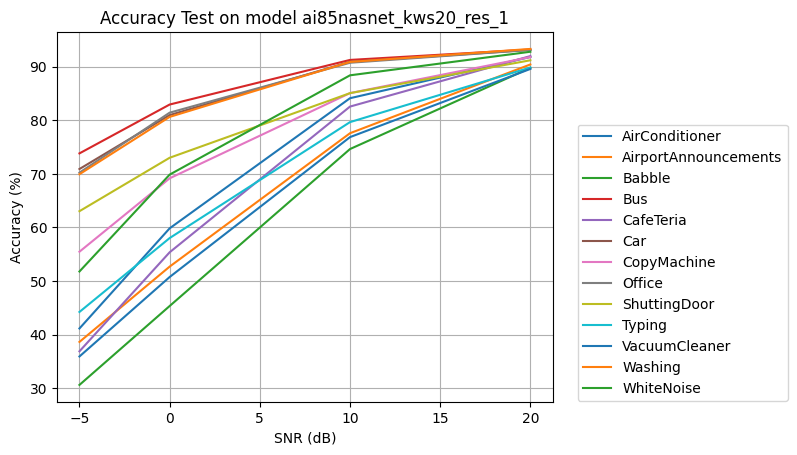

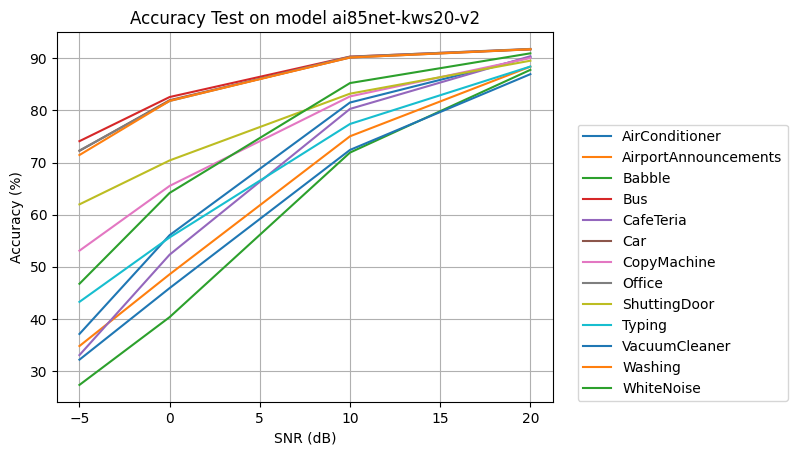

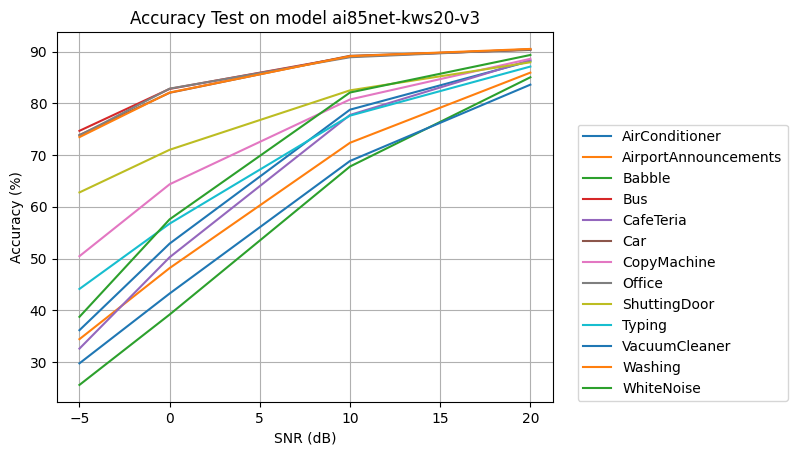

In [63]:
snr = [-5, 0, 10, 20]

for model_num in data_files.columns[2:]:
    accuracies_values = plot(model_num)
    plt.figure()
    plt.grid()
    for noise in noise_list:
        plt.title(f'Accuracy Test on model {model_num}') #duzelecek
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy (%)')
        plt.plot(snr, accuracies_values[noise])

    plt.legend(noise_list, bbox_to_anchor=(1.05, 0.75),
                         loc='upper left', borderaxespad=0.)

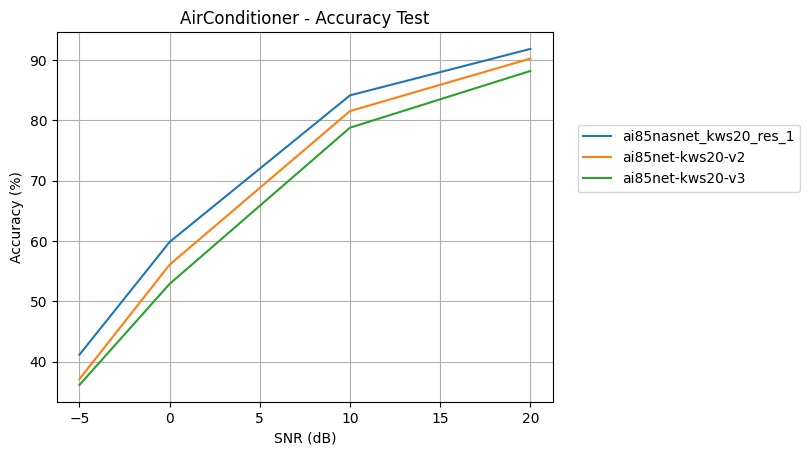

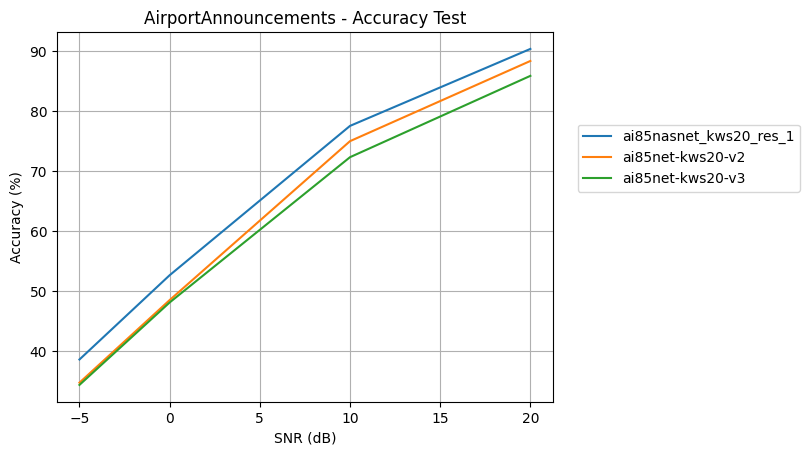

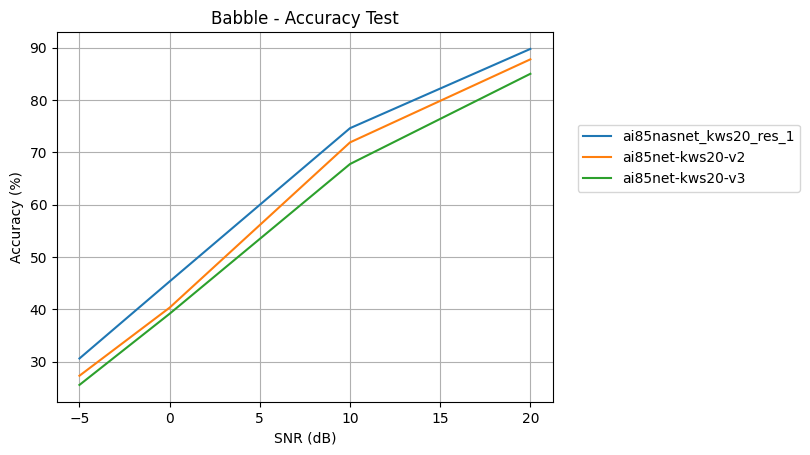

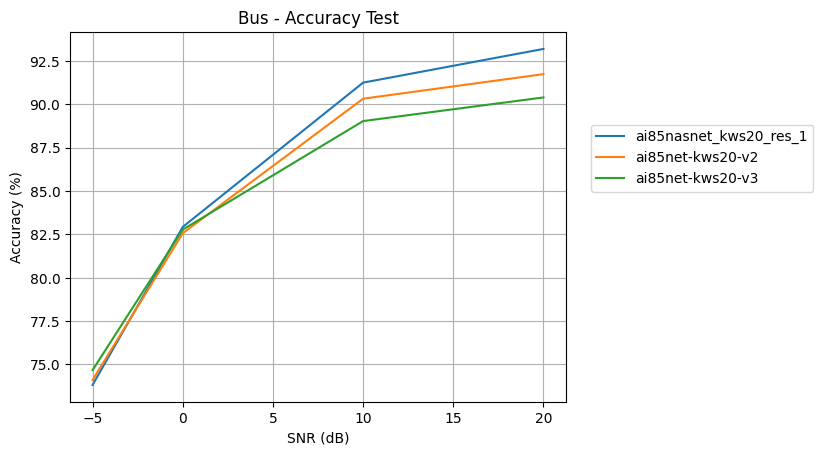

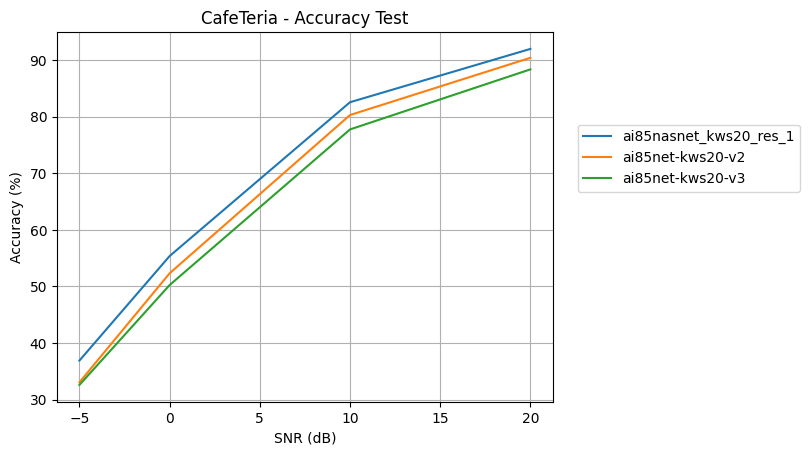

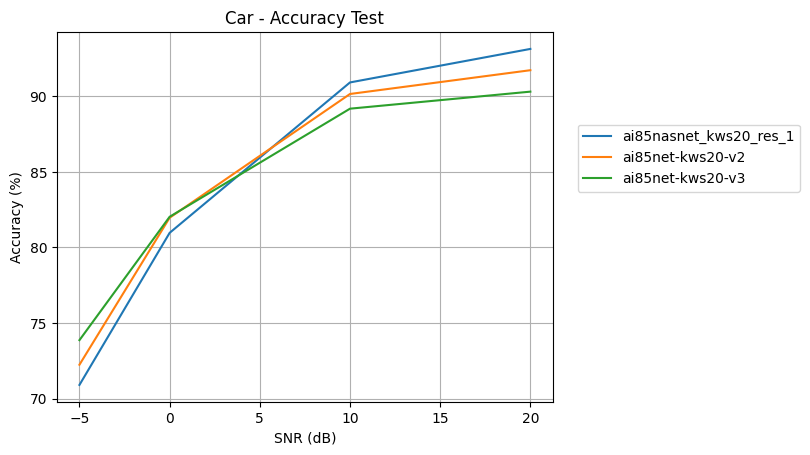

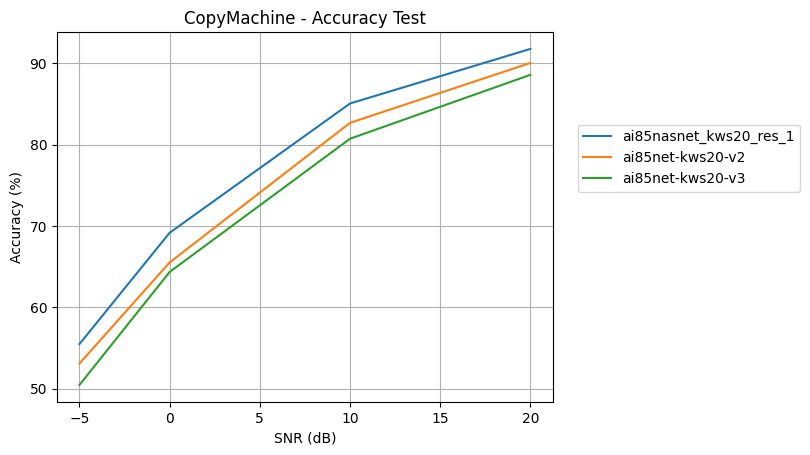

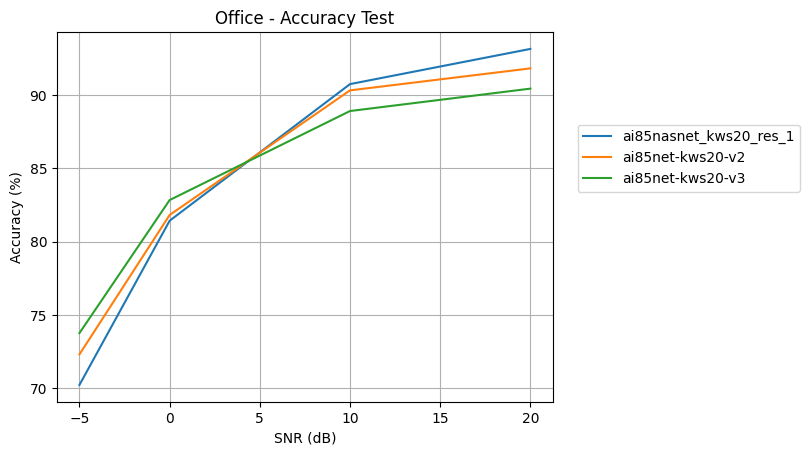

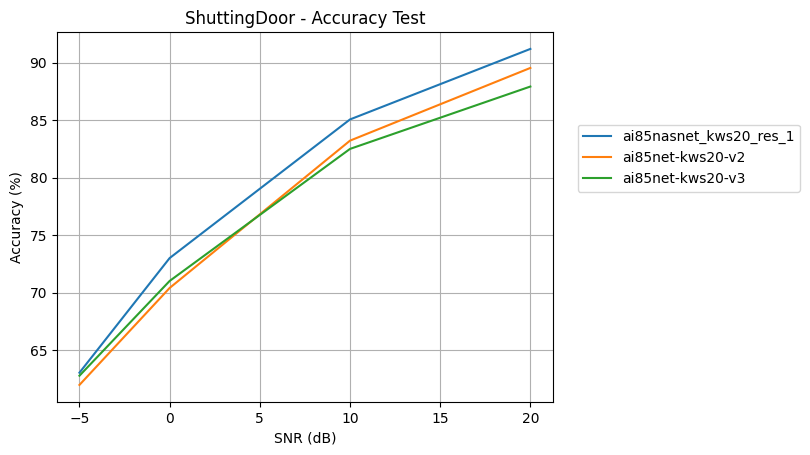

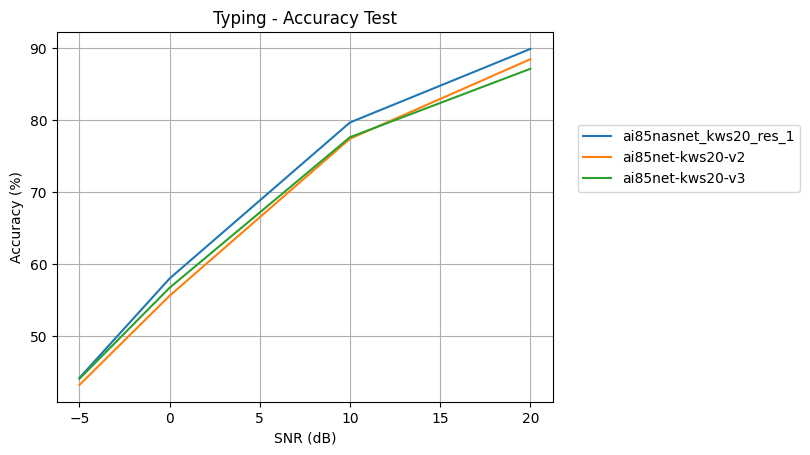

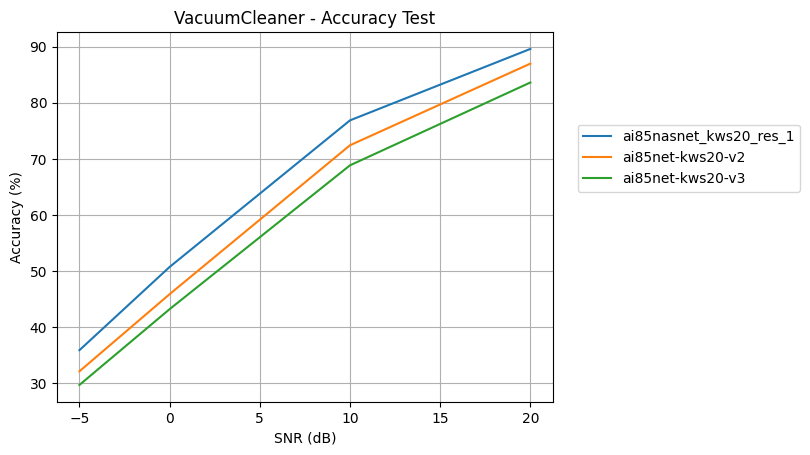

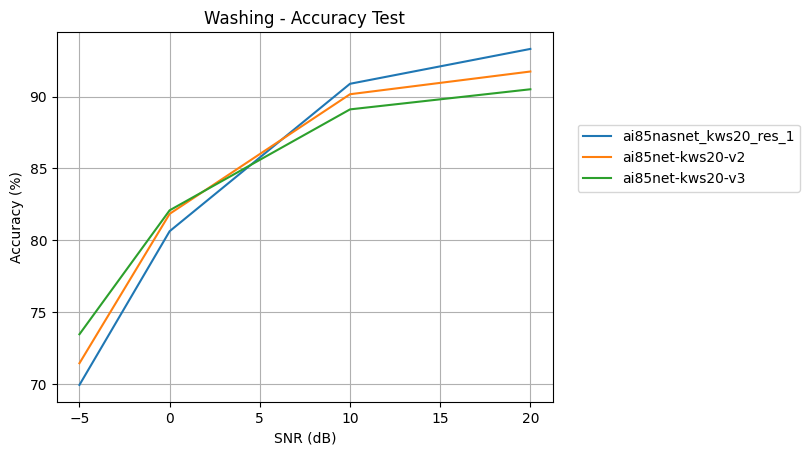

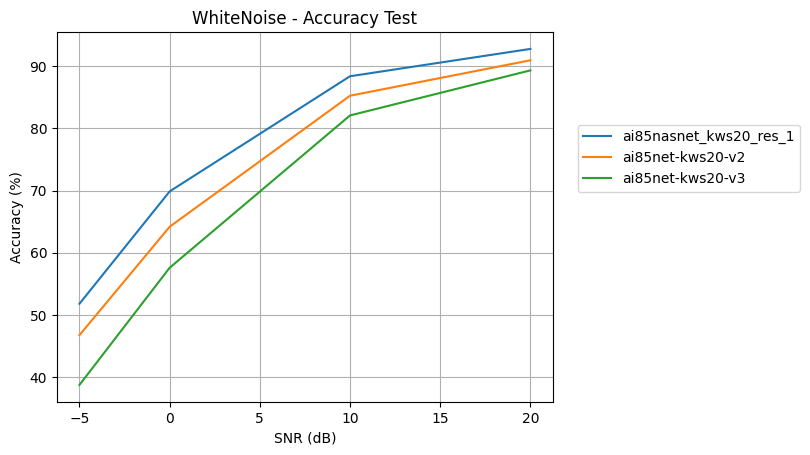

In [64]:
snr = [-5, 0, 10, 20]
acc_list = []
for model_num in data_files.columns[2:]:
    acc_list.append(plot(model_num))
    
for noise in noise_list:
    plt.figure()
    plt.grid()
    plt.title(f'{noise} - Accuracy Test')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy (%)')
    for model in acc_list:
        plt.plot(snr , model[noise])

    plt.legend(data_files.columns[2:], bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)

/tmp/ipykernel_3501103/2098196639.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


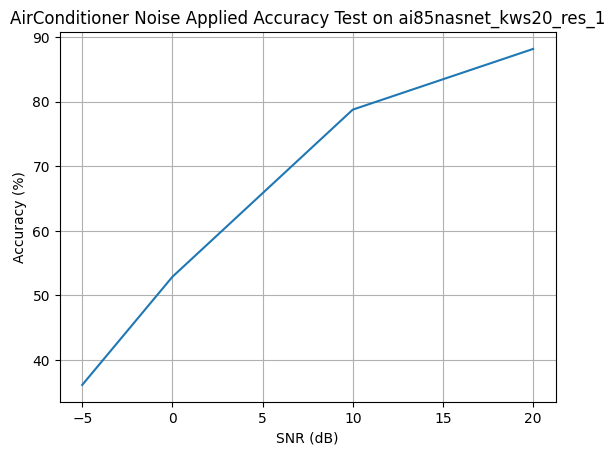

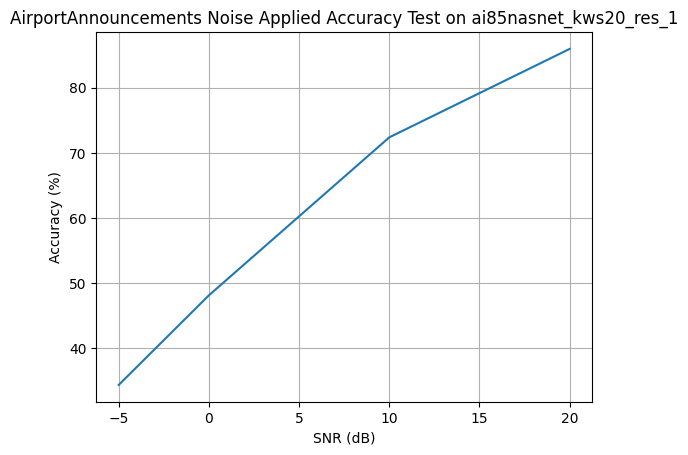

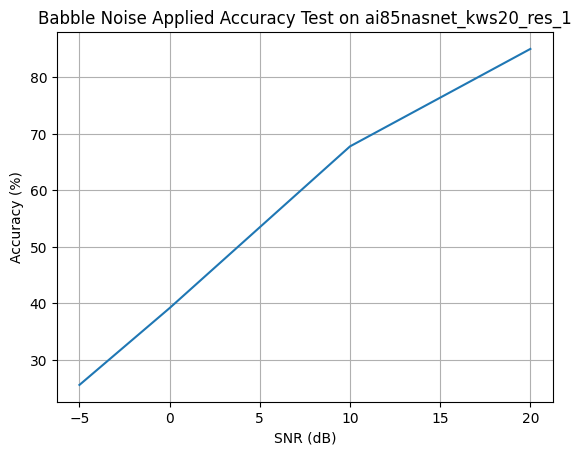

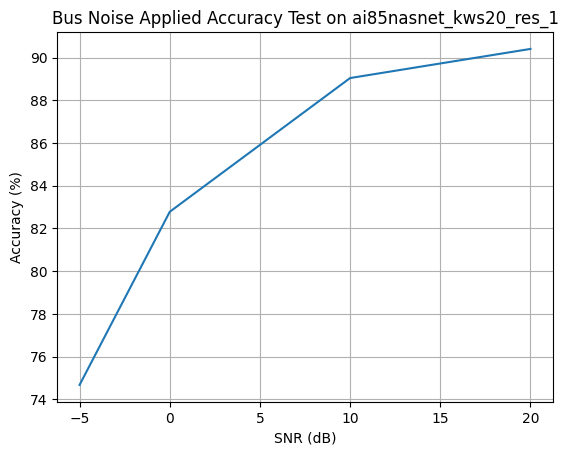

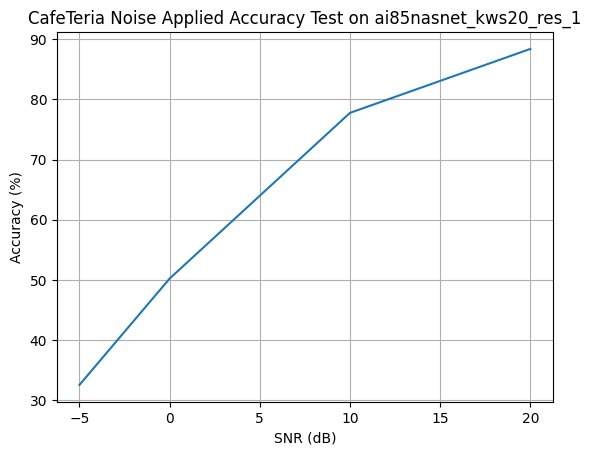

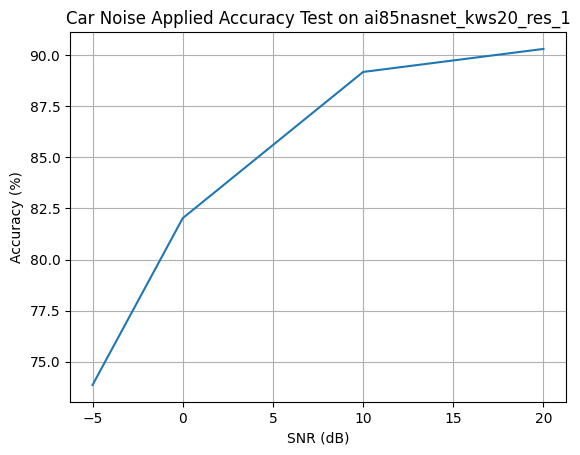

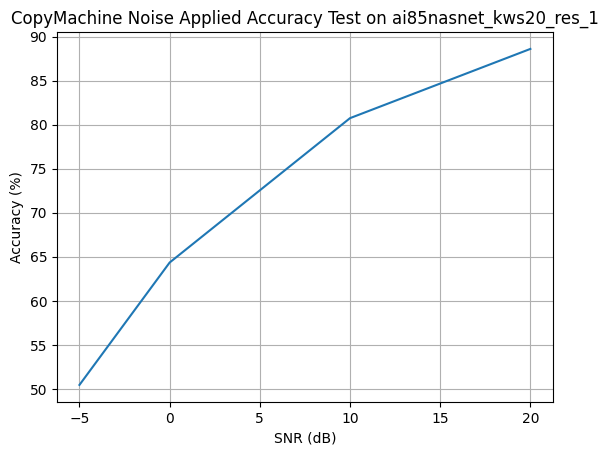

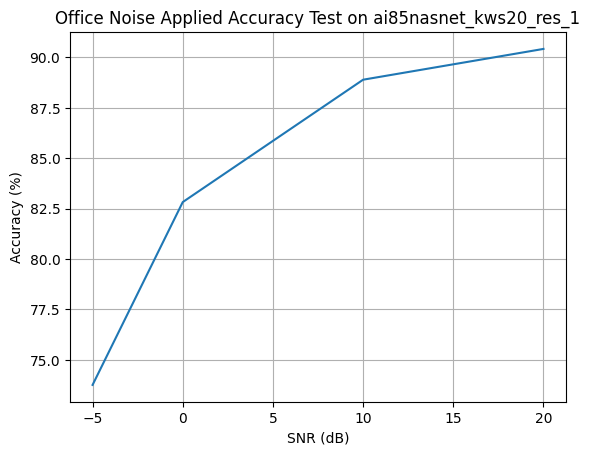

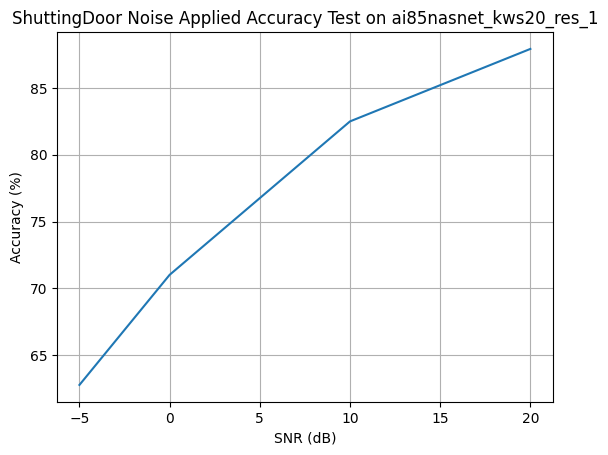

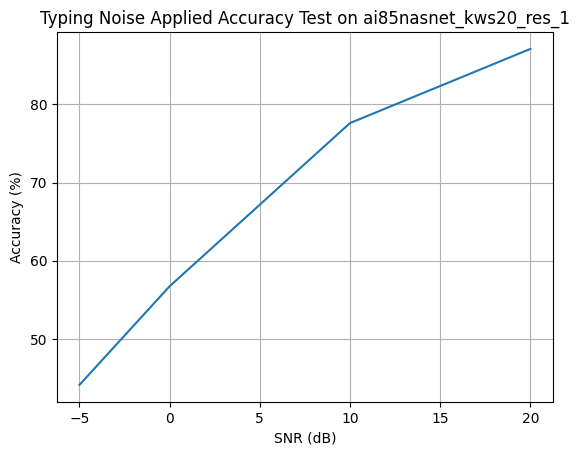

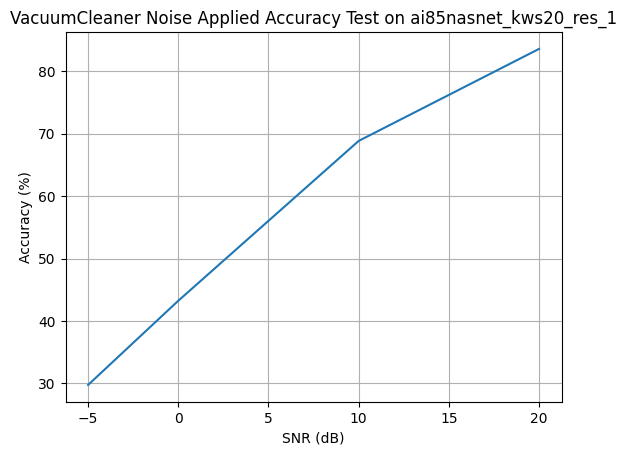

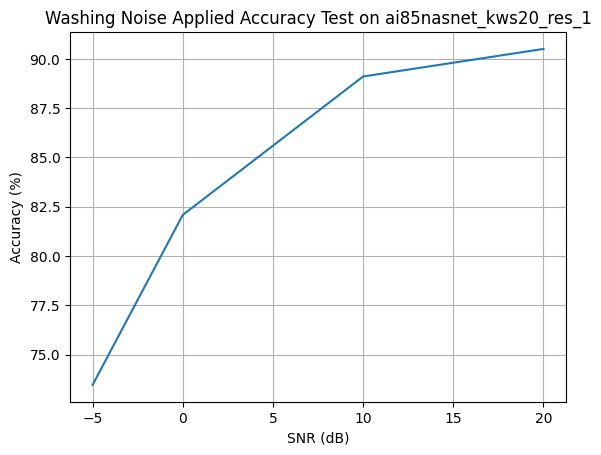

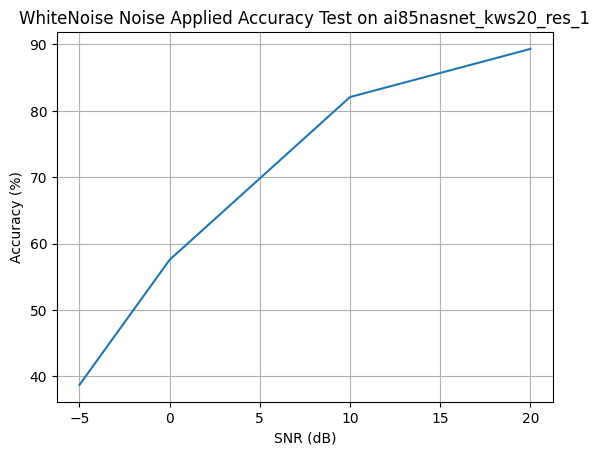

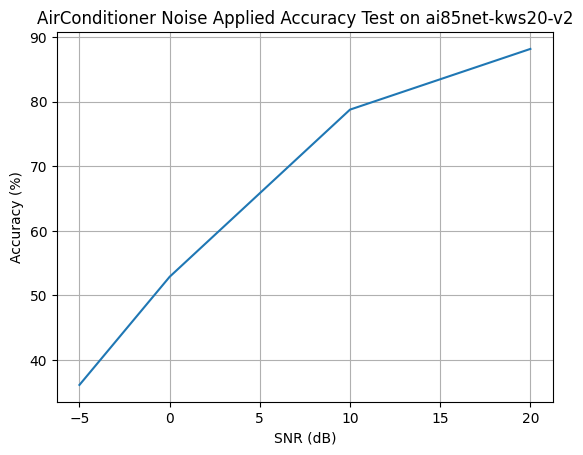

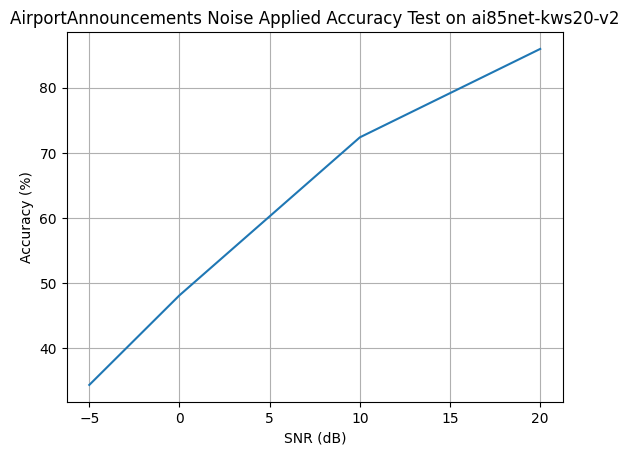

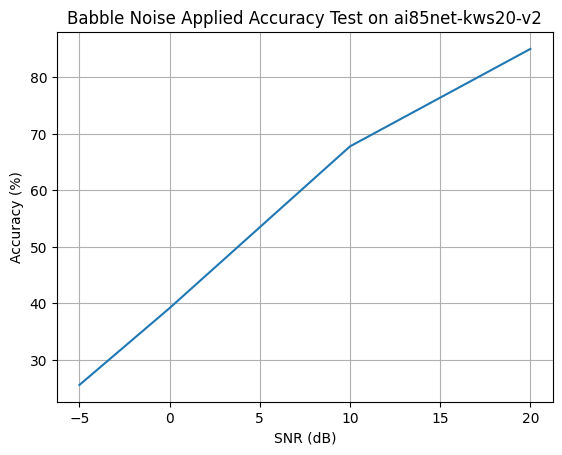

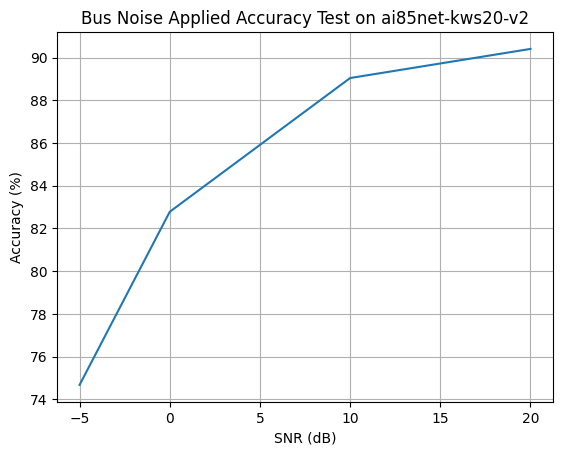

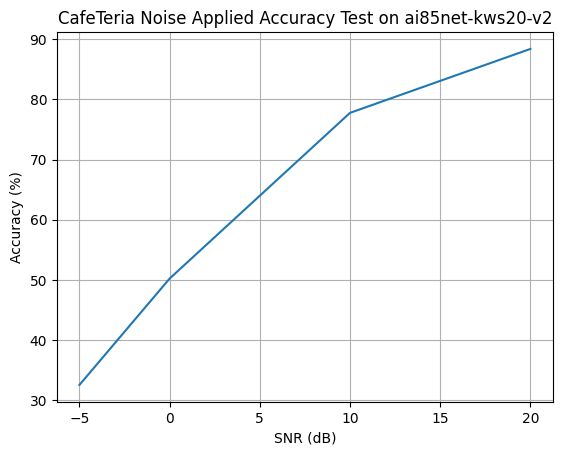

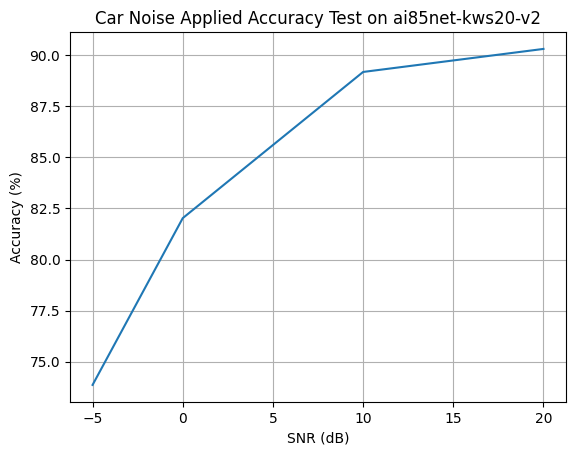

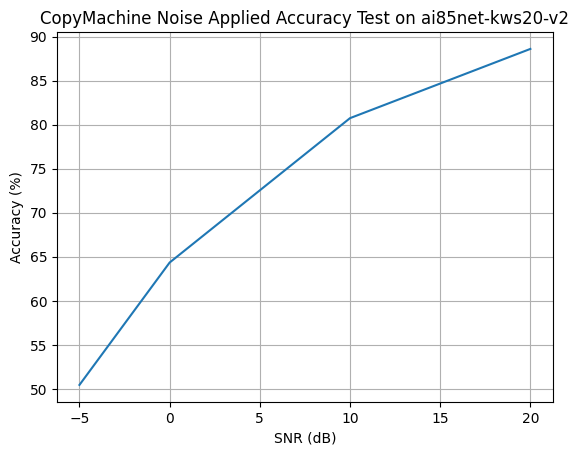

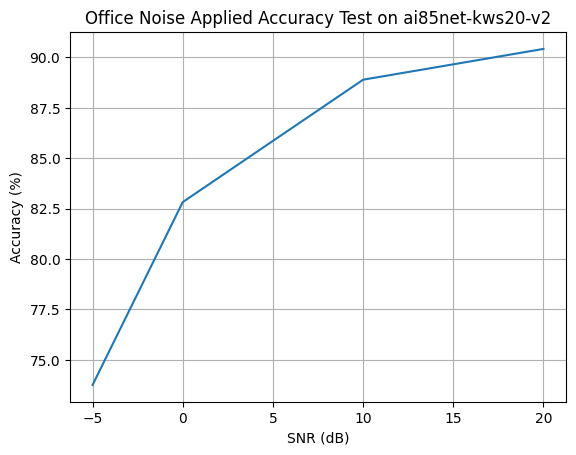

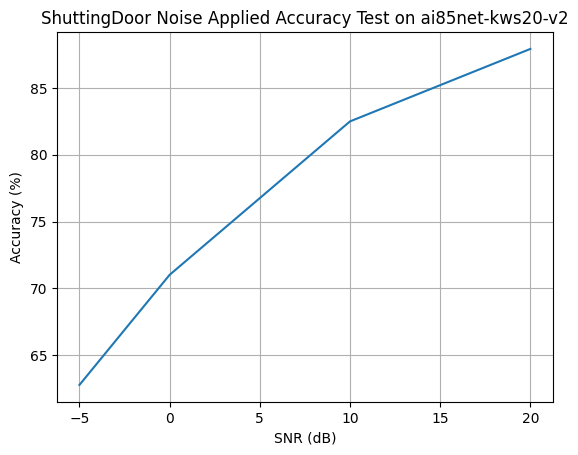

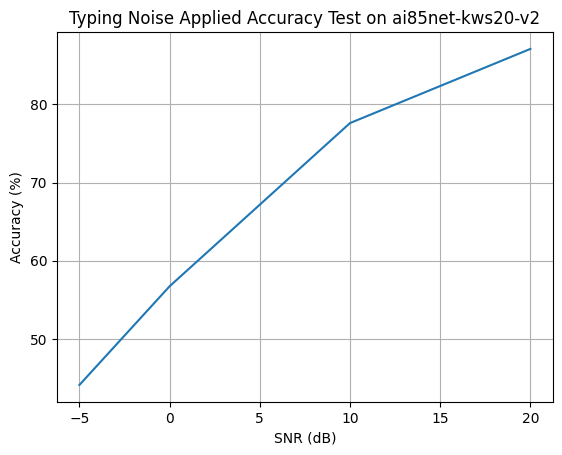

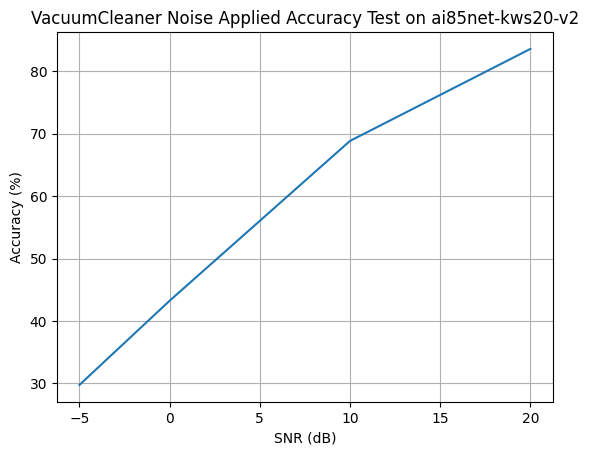

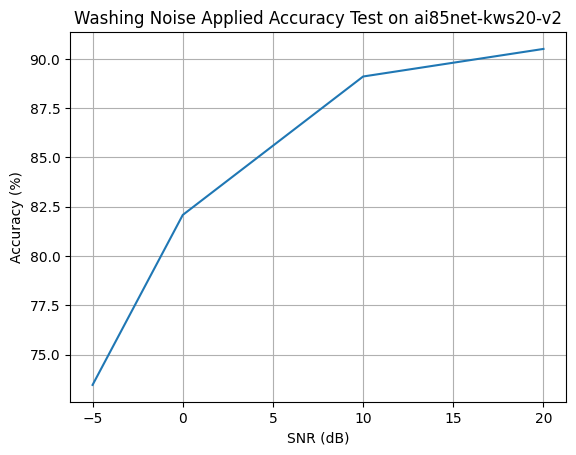

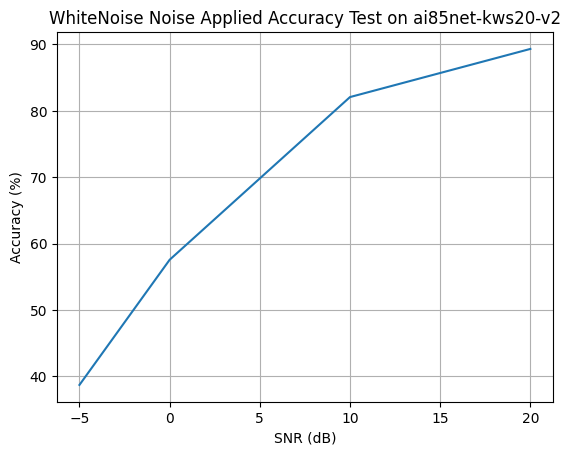

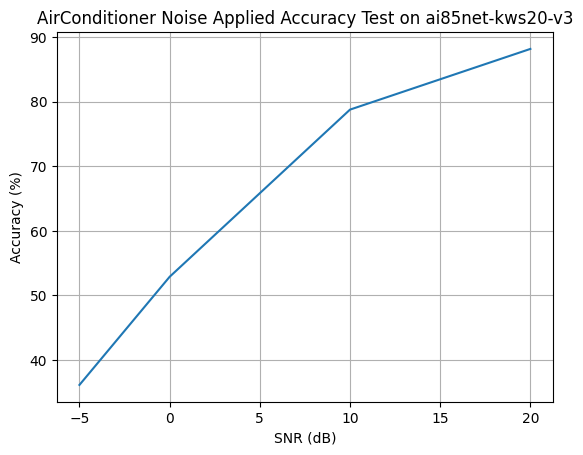

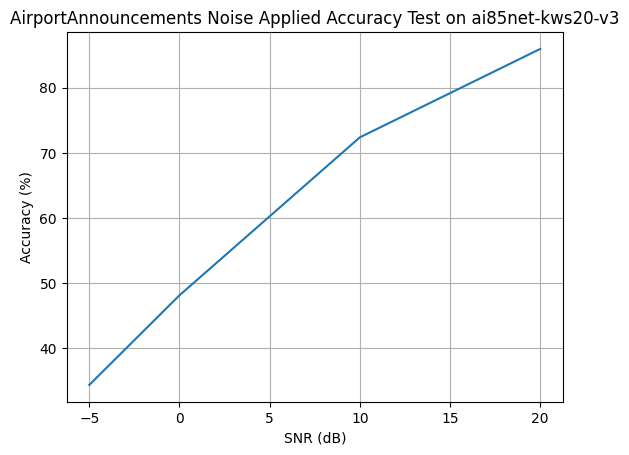

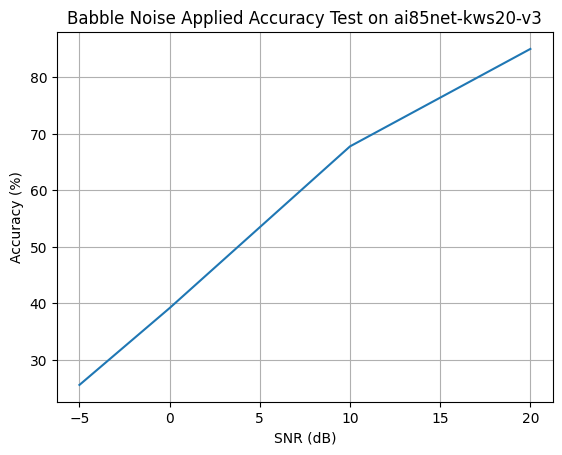

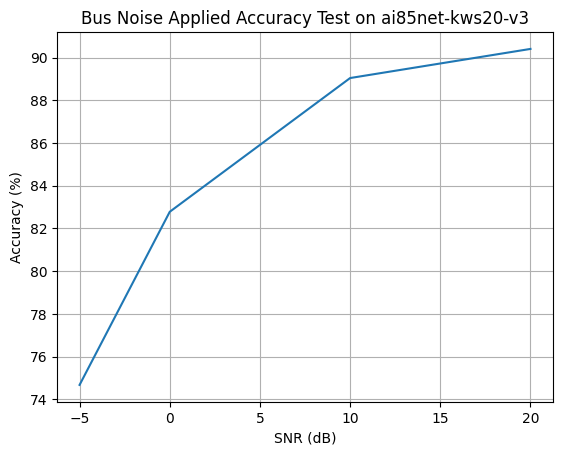

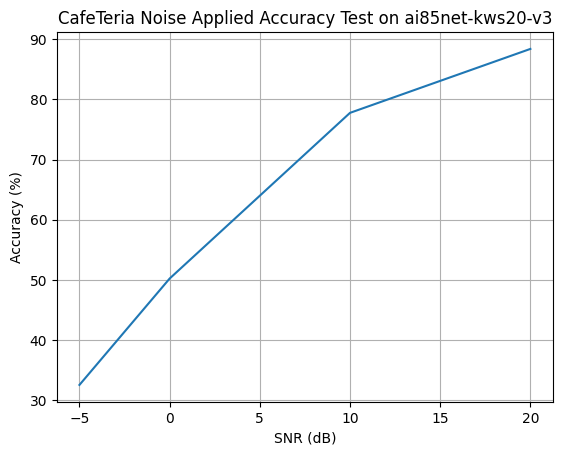

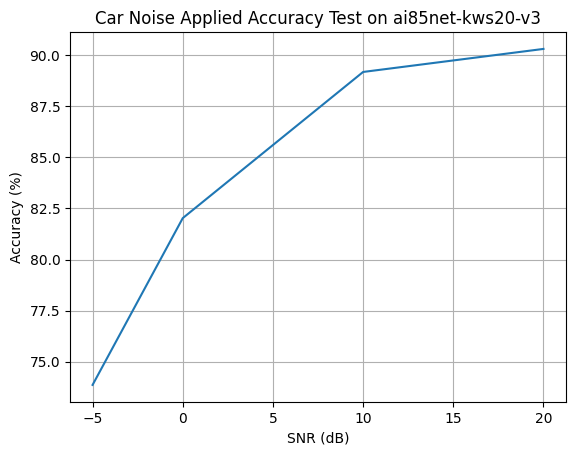

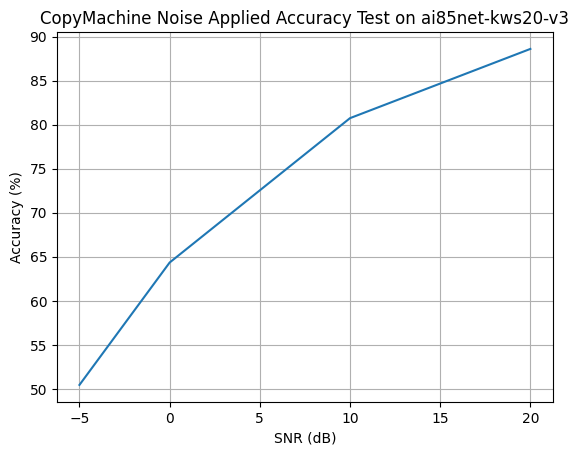

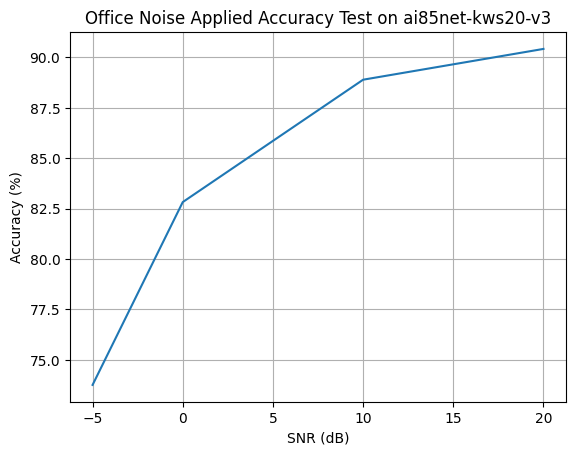

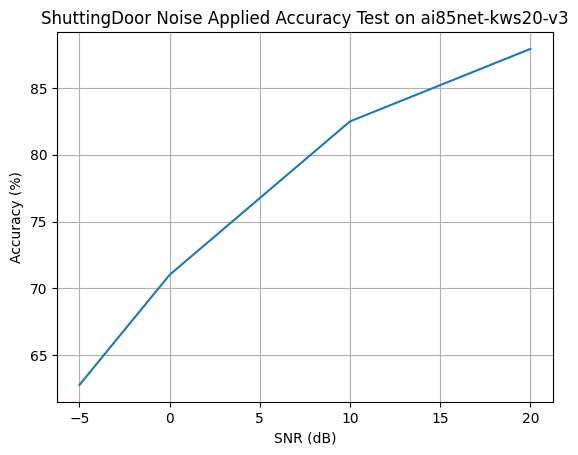

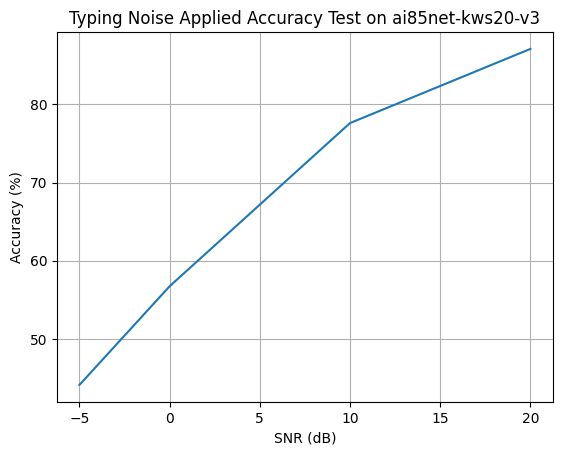

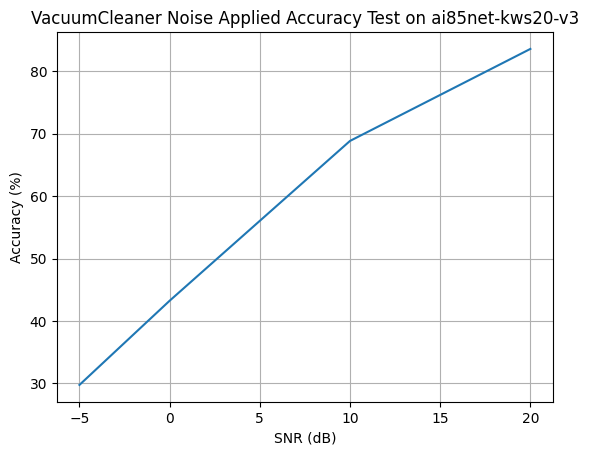

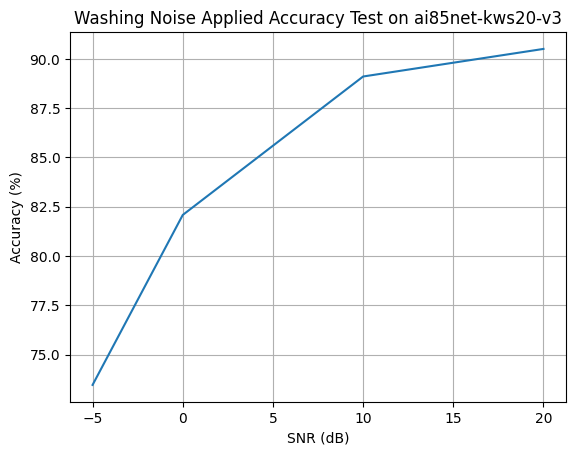

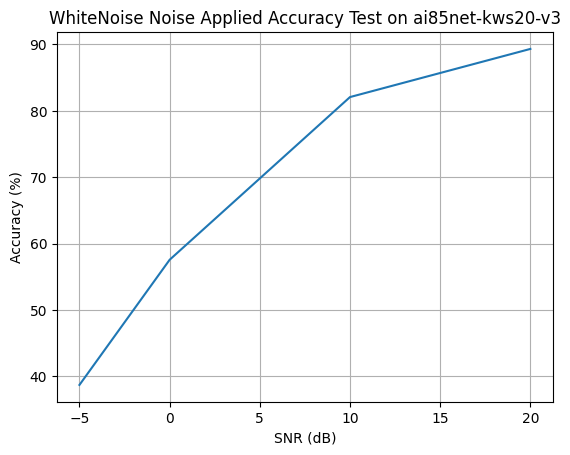

In [65]:
snr = [-5, 0, 10, 20]

for model_num in data_files.columns[2:]:
    for noise in noise_list:
        plt.figure()
        plt.grid()
        plt.title(f'{noise} Noise Applied Accuracy Test on {model_num}')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy (%)')
        plt.plot(snr, accuracies_values[noise])